# Setup the Env

In [1]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/rachel


# Import libraries

In [2]:
# standard libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

!pip install seaborn -q
import seaborn as sns

# Download Data from S3 as needed

In [3]:
cpst = "CRSP/2018-2023_crsp_compustat_quarterly.csv"
cpst_path = s3_download(cpst)

# Load the dataset

https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/fundamentals-quarterly/

Load the full df from 2018 to 2023 so we can use the 2018 data to forward fill missing 2019 data if needed.

In [4]:
df = pd.read_csv("/home/sagemaker-user/capstone-2024-summer/data/2018-2023_crsp_compustat_quarterly.csv", parse_dates=["datadate"])

df.head()

/tmp/ipykernel_622/252997020.py:1: DtypeWarning: Columns (2,19,24,25,33,37,654,657,675,676,681) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/sagemaker-user/capstone-2024-summer/data/2018-2023_crsp_compustat_quarterly.csv", parse_dates=["datadate"])


,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyearq,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1004,P,01,LU,54594,20000,1972-04-24,E,2018-02-28,2017,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
1,1004,P,01,LU,54594,20000,1972-04-24,E,2018-05-31,2017,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
2,1004,P,01,LU,54594,20000,1972-04-24,E,2018-08-31,2018,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
3,1004,P,01,LU,54594,20000,1972-04-24,E,2018-11-30,2018,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
4,1004,P,01,LU,54594,20000,1972-04-24,E,2019-02-28,2018,...,1.0,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24


In [5]:
sp_df = pd.read_csv("/home/sagemaker-user/capstone-2024-summer/data/security_master.csv")

sp_df.head()

,cusip,PERMNO,PERMCO,HSHRCD,DLSTCD,HTICK,HCOMNAM,HTSYMBOL,HNAICS,HPRIMEXC,...,NUMDEL,NUMNDI,BEGDAT,ENDDAT,BEGPRC,ENDPRC,BEGRET,ENDRET,BEGVOL,ENDVOL
0,00130H10,76712,10996,11,100,AES,A E S CORP,AES,221118,N,...,1,68,06/26/1991,12/29/2023,06/26/1991,12/29/2023,06/26/1991,12/29/2023,06/26/1991,12/29/2023
1,00206R10,66093,21645,11,100,T,A T & T INC,T,517312,N,...,1,0,02/16/1984,12/29/2023,02/16/1984,12/29/2023,02/16/1984,12/29/2023,02/16/1984,12/29/2023
2,00507V10,79678,12499,11,233,NaN,ACTIVISION BLIZZARD INC,ATVI,513210,Q,...,1,1968,10/22/1993,10/12/2023,10/22/1993,10/12/2023,10/22/1993,10/12/2023,10/22/1993,10/12/2023
3,00724F10,75510,8476,11,100,ADBE,ADOBE INC,ADBE,511210,Q,...,1,2185,08/13/1986,12/29/2023,08/13/1986,12/29/2023,08/13/1986,12/29/2023,08/13/1986,12/29/2023
4,00971T10,87299,17300,11,100,AKAM,AKAMAI TECHNOLOGIES INC,AKAM,511210,Q,...,1,1722,10/29/1999,12/29/2023,10/29/1999,12/29/2023,10/29/1999,12/29/2023,10/29/1999,12/29/2023


# Take a look at the columns

In [6]:
df.columns

Index(['GVKEY', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT',
       'LINKENDDT', 'datadate', 'fyearq',
       ...
       'priusa', 'sic', 'spcindcd', 'spcseccd', 'spcsrc', 'state', 'stko',
       'weburl', 'dldte', 'ipodate'],
      dtype='object', length=687)

In [7]:
df.dtypes

GVKEY         int64
LINKPRIM     object
LIID         object
LINKTYPE     object
LPERMNO       int64
             ...   
state        object
stko        float64
weburl       object
dldte        object
ipodate      object
Length: 687, dtype: object

In [8]:
og_len = len(df)
og_cols = len(df.columns)
og_pernmno = len(df["LPERMNO"].unique())
print("number of records:", og_len)
print("number of columns:", og_cols)
print("number of permno:", og_pernmno)

number of records: 195689
number of columns: 687
number of permno: 11765


# Null analysis

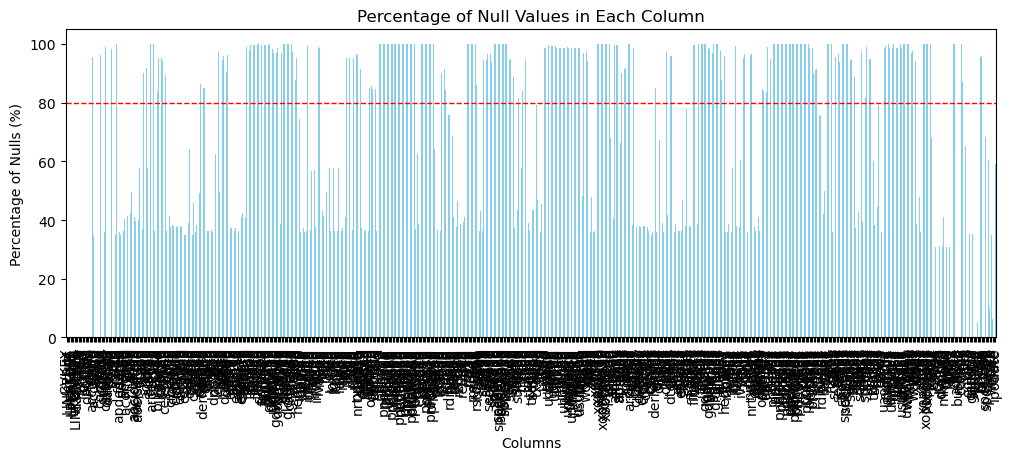

In [9]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.axhline(y=80, color='red', linestyle='--', linewidth=1)
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Nulls (%)')
plt.show()

## A1. Keep only columns we definitely need

In [10]:
og_cols = len(df.columns)
columns_to_keep = ["GVKEY", # SP_id
                   "LPERMNO", # permno_id
                   'tic', # sp_ticker
                   'cusip', # sp_cusip_id
                   'conm', # sp_company_name
                   'datadate', # data_date
                   'rp', # report_frequency
                   'updq', # data_status
                   'busdesc', # company_description
                   'actq', # st_assets
                   'ancq', # lt_assets
                   'aoq',  # oth_assets
                   'atq',  # assets
                   'lctq', # st_liabs
                   'lltq', # lt_liabs
                   'loq', # oth_liabs
                   'ltq', # liabs
                   'req', # retained_earning
                   'teqq', # equity
                   'revtq', # revenue
                   'saleq', # net_sales
                   'cogsq', # cogs
                   'xoprq', # operating_exp
                   'xrdq', # RD_exp
                   'xsgaq', # SGA_exp
                   'aqpy', # MA_exp
                   'ibq', # income_b4_extraordinary
                   'piq', # pretax_income
                   'txtq', # income_tax
                   'niq', # net_income
                   'cshiq', # common_shares_issued
                   'cshoq', # common_shares_outstanding
                   'pstkq', # preferred_stock
                   'epsfiq', # earnings_per_share_diluted_w_extraordinary
                   'epsfxq', # earnings_per_share_diluted_wo_extraordinary
                   'epspiq', # earnings_per_share_basic_w_extraordinary
                   'epspxq', # earnings_per_share_basic_wo_extraordinary
                   ]
df = df[columns_to_keep]
new_cols = len(df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

df = df[columns_to_keep]

num_columns_removed:  650
num_columns_kept: 37


## A2. Rename & Reorder all columns

In [11]:
rename_dict = {
    "GVKEY": "sp_SP_id",
    "LPERMNO": "permno_id",
    'tic': "sp_ticker",
    'cusip': "sp_cusip_id",
    'conm': "sp_company_name",
    'datadate': "data_date",
    'rp': "report_frequency",
    'updq': "data_status",
    'busdesc': "company_description",
    'actq': "st_assets",
    'ancq': "lt_assets",
    'aoq': "oth_assets",
    'atq': "assets",
    'lctq': "st_liabs",
    'lltq': "lt_liabs",
    'loq': "oth_liabs",
    'ltq': "liabs",
    'req': "retained_earning",
    'teqq': "equity",
    'revtq': "revenue",
    'saleq': "net_sales",
    'cogsq': "cogs",
    'xoprq': "operating_exp",
    'xrdq': "RD_exp",
    'xsgaq': "SGA_exp",
    'aqpy': "MA_exp",
    'ibq': "income_b4_extraordinary",
    'piq': "pretax_income",
    'txtq': "income_tax",
    'niq': "net_income",
    'cshiq': "common_shares_issued",
    'cshoq': "common_shares_outstanding",
    'pstkq': "preferred_stock",
    'epsfiq': "earnings_per_share_diluted_w_extraordinary",
    'epsfxq': "earnings_per_share_diluted_wo_extraordinary",
    'epspiq': "earnings_per_share_basic_w_extraordinary",
    'epspxq': "earnings_per_share_basic_wo_extraordinary"
}

df = df.rename(columns=rename_dict)
df = df[list(rename_dict.values())]

In [12]:
financials = [
    'st_assets',
    'lt_assets',
    'oth_assets',
    'assets',
    'st_liabs',
    'lt_liabs',
    'oth_liabs',
    'liabs',
    'retained_earning',
    'equity',
    'revenue',
    'net_sales',
    'cogs',
    'operating_exp',
    'RD_exp',
    'SGA_exp',
    'MA_exp',
    'income_b4_extraordinary',
    'pretax_income',
    'income_tax',
    'net_income',
    'common_shares_issued',
    'common_shares_outstanding',
    'preferred_stock',
    'earnings_per_share_diluted_w_extraordinary',
    'earnings_per_share_diluted_wo_extraordinary',
    'earnings_per_share_basic_w_extraordinary',
    'earnings_per_share_basic_wo_extraordinary'
]

# Take another look at the null analysis

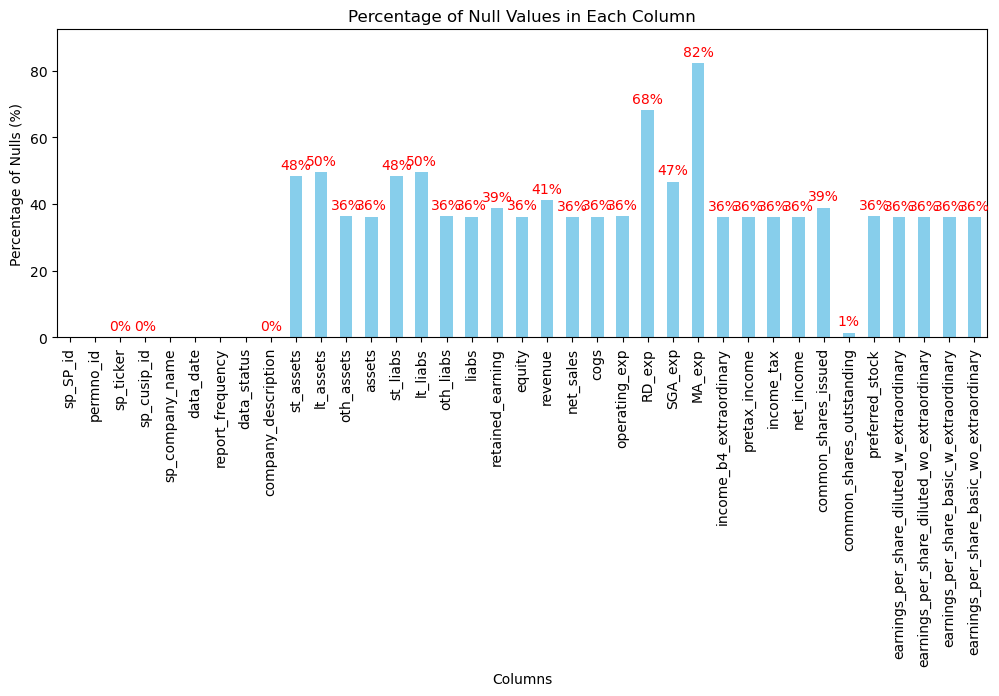

In [13]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## B1. Keep only securities within security_master

In [14]:
sp_permno = sp_df["PERMNO"].unique()
df = df[df["permno_id"].isin(sp_permno)].reset_index(drop=True)

display(len(df))
display(len(df["permno_id"].unique()))

13397

568

# Take another look at the null analysis

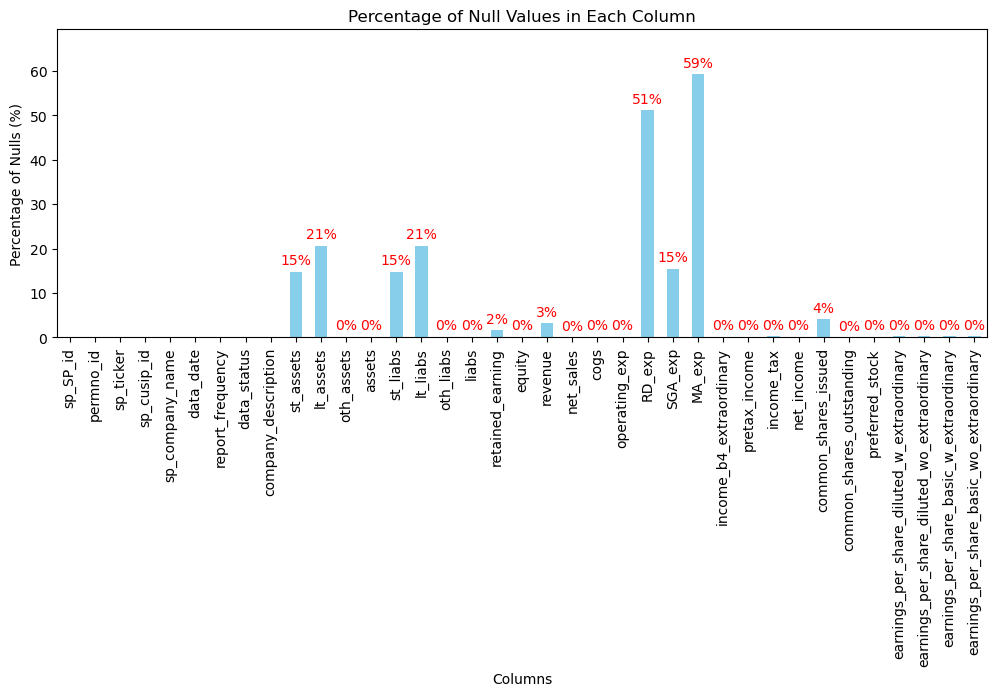

In [15]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## Investigate companies with missing total assets

permno == 16048, 75418, 93337

In [16]:
df[df["assets"].isnull()]["permno_id"].unique()

array([16048, 75418, 93337])

## Investigate permno == 16048

In [17]:
permno = 16048
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
5958,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4127.200,...,204.512,51.744,152.768,NaN,484.586,0.0,0.31,0.31,0.32,0.32
5959,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4427.892,...,448.879,115.104,333.775,486.108,486.108,0.0,0.68,0.68,0.68,0.68
5960,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4339.759,...,552.678,138.736,413.942,NaN,486.108,0.0,0.85,0.85,0.86,0.86
5961,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3424.389,...,173.533,33.306,140.227,474.920,474.920,0.0,0.29,0.29,0.29,0.29
5962,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",NaN,...,NaN,NaN,NaN,NaN,474.920,NaN,NaN,NaN,NaN,NaN
5963,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4168.479,...,771.561,193.459,578.102,466.671,466.671,0.0,1.22,1.22,1.23,1.23
5964,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",NaN,...,NaN,NaN,NaN,NaN,466.671,NaN,NaN,NaN,NaN,NaN
5965,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3482.133,...,860.093,215.016,645.077,456.400,456.400,0.0,1.38,1.38,1.40,1.40
5966,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",NaN,...,NaN,NaN,NaN,NaN,456.400,NaN,NaN,NaN,NaN,NaN
5967,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4273.264,...,237.466,95.662,141.804,454.164,454.164,0.0,0.32,0.32,0.32,0.32


### C1. Look like permno_id == 16048 only reports their financials twice a year, let's forward fill using last quarter's value

In [18]:
df_permno = df[df["permno_id"]==permno]
df_permno[financials] = df_permno[financials].ffill()

/tmp/ipykernel_622/4172421690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_permno[financials] = df_permno[financials].ffill()


In [19]:
df_permno

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
5958,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4127.200,...,204.512,51.744,152.768,NaN,484.586,0.0,0.31,0.31,0.32,0.32
5959,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4427.892,...,448.879,115.104,333.775,486.108,486.108,0.0,0.68,0.68,0.68,0.68
5960,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4339.759,...,552.678,138.736,413.942,486.108,486.108,0.0,0.85,0.85,0.86,0.86
5961,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3424.389,...,173.533,33.306,140.227,474.920,474.920,0.0,0.29,0.29,0.29,0.29
5962,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3424.389,...,173.533,33.306,140.227,474.920,474.920,0.0,0.29,0.29,0.29,0.29
5963,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4168.479,...,771.561,193.459,578.102,466.671,466.671,0.0,1.22,1.22,1.23,1.23
5964,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4168.479,...,771.561,193.459,578.102,466.671,466.671,0.0,1.22,1.22,1.23,1.23
5965,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3482.133,...,860.093,215.016,645.077,456.400,456.400,0.0,1.38,1.38,1.40,1.40
5966,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3482.133,...,860.093,215.016,645.077,456.400,456.400,0.0,1.38,1.38,1.40,1.40
5967,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4273.264,...,237.466,95.662,141.804,454.164,454.164,0.0,0.32,0.32,0.32,0.32


In [20]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4127.200,...,204.512,51.744,152.768,NaN,484.586,0.0,0.31,0.31,0.32,0.32
13374,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4427.892,...,448.879,115.104,333.775,486.108,486.108,0.0,0.68,0.68,0.68,0.68
13375,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4339.759,...,552.678,138.736,413.942,486.108,486.108,0.0,0.85,0.85,0.86,0.86
13376,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2018-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3424.389,...,173.533,33.306,140.227,474.920,474.920,0.0,0.29,0.29,0.29,0.29
13377,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3424.389,...,173.533,33.306,140.227,474.920,474.920,0.0,0.29,0.29,0.29,0.29
13378,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4168.479,...,771.561,193.459,578.102,466.671,466.671,0.0,1.22,1.22,1.23,1.23
13379,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-09-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4168.479,...,771.561,193.459,578.102,466.671,466.671,0.0,1.22,1.22,1.23,1.23
13380,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2019-12-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3482.133,...,860.093,215.016,645.077,456.400,456.400,0.0,1.38,1.38,1.40,1.40
13381,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-03-31,Q,3,"Coca-Cola Europacific Partners PLC, together w...",3482.133,...,860.093,215.016,645.077,456.400,456.400,0.0,1.38,1.38,1.40,1.40
13382,12756,16048,CCEP,G25839104,COCA-COLA EUROPACIFIC PARTNE,2020-06-30,Q,3,"Coca-Cola Europacific Partners PLC, together w...",4273.264,...,237.466,95.662,141.804,454.164,454.164,0.0,0.32,0.32,0.32,0.32


## Investigate permno == 75418

In [21]:
permno = 75418

df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
6459,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-03-31,SA,3,Vodafone Group Public Limited Company provides...,46756.0,...,2228.0,-1767.0,1669.0,2881.480,2667.577,0.0,0.61,1.32,0.61,1.33
6460,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-06-30,SA,3,Vodafone Group Public Limited Company provides...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6461,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-09-30,SA,3,Vodafone Group Public Limited Company provides...,37439.0,...,-3308.0,1650.0,-9219.0,NaN,2667.577,0.0,-3.37,-1.86,-3.37,-1.86
6462,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-12-31,SA,3,Vodafone Group Public Limited Company provides...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6463,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-03-31,SA,3,Vodafone Group Public Limited Company provides...,44690.0,...,375.0,29.0,217.0,2881.526,2723.038,0.0,0.08,0.04,0.09,0.04
6464,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-06-30,SA,3,Vodafone Group Public Limited Company provides...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6465,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-09-30,SA,3,Vodafone Group Public Limited Company provides...,29377.0,...,-557.0,1505.0,-2320.0,NaN,2723.038,0.0,-0.79,-0.79,-0.79,-0.79
6466,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-12-31,SA,3,Vodafone Group Public Limited Company provides...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6467,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-03-31,SA,3,Vodafone Group Public Limited Company provides...,36533.0,...,1431.0,-131.0,1309.0,2881.591,2677.216,0.0,0.45,0.45,0.45,0.45
6468,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-06-30,SA,3,Vodafone Group Public Limited Company provides...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### C2. Look like permno_id == 75418 only reports their financials twice a year, let's forward fill using last quarter's value

In [22]:
df_permno = df[df["permno_id"]==permno]
df_permno[financials] = df_permno[financials].ffill()

/tmp/ipykernel_622/4172421690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_permno[financials] = df_permno[financials].ffill()


In [23]:
df_permno

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
6459,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-03-31,SA,3,Vodafone Group Public Limited Company provides...,46756.0,...,2228.0,-1767.0,1669.0,2881.480,2667.577,0.0,0.61,1.32,0.61,1.33
6460,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-06-30,SA,3,Vodafone Group Public Limited Company provides...,46756.0,...,2228.0,-1767.0,1669.0,2881.480,2667.577,0.0,0.61,1.32,0.61,1.33
6461,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-09-30,SA,3,Vodafone Group Public Limited Company provides...,37439.0,...,-3308.0,1650.0,-9219.0,2881.480,2667.577,0.0,-3.37,-1.86,-3.37,-1.86
6462,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-12-31,SA,3,Vodafone Group Public Limited Company provides...,37439.0,...,-3308.0,1650.0,-9219.0,2881.480,2667.577,0.0,-3.37,-1.86,-3.37,-1.86
6463,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-03-31,SA,3,Vodafone Group Public Limited Company provides...,44690.0,...,375.0,29.0,217.0,2881.526,2723.038,0.0,0.08,0.04,0.09,0.04
6464,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-06-30,SA,3,Vodafone Group Public Limited Company provides...,44690.0,...,375.0,29.0,217.0,2881.526,2723.038,0.0,0.08,0.04,0.09,0.04
6465,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-09-30,SA,3,Vodafone Group Public Limited Company provides...,29377.0,...,-557.0,1505.0,-2320.0,2881.526,2723.038,0.0,-0.79,-0.79,-0.79,-0.79
6466,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-12-31,SA,3,Vodafone Group Public Limited Company provides...,29377.0,...,-557.0,1505.0,-2320.0,2881.526,2723.038,0.0,-0.79,-0.79,-0.79,-0.79
6467,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-03-31,SA,3,Vodafone Group Public Limited Company provides...,36533.0,...,1431.0,-131.0,1309.0,2881.591,2677.216,0.0,0.45,0.45,0.45,0.45
6468,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-06-30,SA,3,Vodafone Group Public Limited Company provides...,36533.0,...,1431.0,-131.0,1309.0,2881.591,2677.216,0.0,0.45,0.45,0.45,0.45


In [24]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-03-31,SA,3,Vodafone Group Public Limited Company provides...,46756.0,...,2228.0,-1767.0,1669.0,2881.480,2667.577,0.0,0.61,1.32,0.61,1.33
13374,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-06-30,SA,3,Vodafone Group Public Limited Company provides...,46756.0,...,2228.0,-1767.0,1669.0,2881.480,2667.577,0.0,0.61,1.32,0.61,1.33
13375,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-09-30,SA,3,Vodafone Group Public Limited Company provides...,37439.0,...,-3308.0,1650.0,-9219.0,2881.480,2667.577,0.0,-3.37,-1.86,-3.37,-1.86
13376,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2018-12-31,SA,3,Vodafone Group Public Limited Company provides...,37439.0,...,-3308.0,1650.0,-9219.0,2881.480,2667.577,0.0,-3.37,-1.86,-3.37,-1.86
13377,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-03-31,SA,3,Vodafone Group Public Limited Company provides...,44690.0,...,375.0,29.0,217.0,2881.526,2723.038,0.0,0.08,0.04,0.09,0.04
13378,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-06-30,SA,3,Vodafone Group Public Limited Company provides...,44690.0,...,375.0,29.0,217.0,2881.526,2723.038,0.0,0.08,0.04,0.09,0.04
13379,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-09-30,SA,3,Vodafone Group Public Limited Company provides...,29377.0,...,-557.0,1505.0,-2320.0,2881.526,2723.038,0.0,-0.79,-0.79,-0.79,-0.79
13380,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2019-12-31,SA,3,Vodafone Group Public Limited Company provides...,29377.0,...,-557.0,1505.0,-2320.0,2881.526,2723.038,0.0,-0.79,-0.79,-0.79,-0.79
13381,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-03-31,SA,3,Vodafone Group Public Limited Company provides...,36533.0,...,1431.0,-131.0,1309.0,2881.591,2677.216,0.0,0.45,0.45,0.45,0.45
13382,14894,75418,VOD,92857W308,VODAFONE GROUP PUBLIC LTD,2020-06-30,SA,3,Vodafone Group Public Limited Company provides...,36533.0,...,1431.0,-131.0,1309.0,2881.591,2677.216,0.0,0.45,0.45,0.45,0.45


## Investigate permno == 93337

In [25]:
permno = 93337

df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
10025,63987,93337,VEON,91822M502,VEON LTD,2018-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3406.0,...,159.0,117.0,-112.0,1756.731,1749.127,0.0,-0.06,0.01,-0.06,0.01
10026,63987,93337,VEON,91822M502,VEON LTD,2018-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4819.0,...,162.0,136.0,-142.0,1756.731,1749.127,0.0,-0.09,0.01,-0.09,0.01
10027,63987,93337,VEON,91822M502,VEON LTD,2018-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4749.0,...,-626.0,92.0,855.0,1756.731,1749.127,0.0,0.49,-0.24,0.49,-0.24
10028,63987,93337,VEON,91822M502,VEON LTD,2018-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3110.0,...,57.0,24.0,-19.0,1756.731,1749.127,0.0,-0.01,-0.01,-0.01,-0.01
10029,63987,93337,VEON,91822M502,VEON LTD,2019-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3454.0,...,609.0,79.0,495.0,1756.731,1749.127,0.0,0.28,0.28,0.28,0.28
10030,63987,93337,VEON,91822M502,VEON LTD,2019-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",3332.0,...,256.0,181.0,70.0,1756.731,1749.127,0.0,0.04,0.04,0.04,0.04
10031,63987,93337,VEON,91822M502,VEON LTD,2019-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2553.0,...,130.0,100.0,34.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
10032,63987,93337,VEON,91822M502,VEON LTD,2019-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2499.0,...,186.0,138.0,22.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
10033,63987,93337,VEON,91822M502,VEON LTD,2020-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2736.0,...,195.0,75.0,108.0,1756.731,1749.127,0.0,0.06,0.06,0.06,0.06
10034,63987,93337,VEON,91822M502,VEON LTD,2020-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2366.0,...,195.0,56.0,156.0,1756.731,1749.127,0.0,0.09,0.08,0.09,0.08


### C3. Look like permno_id == 93337 only has a few periods with missing values, let's forward fill using last quarter's value

In [26]:
df_permno = df[df["permno_id"]==permno]
df_permno[financials] = df_permno[financials].ffill()

/tmp/ipykernel_622/4172421690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_permno[financials] = df_permno[financials].ffill()


In [27]:
df_permno

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
10025,63987,93337,VEON,91822M502,VEON LTD,2018-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3406.0,...,159.0,117.0,-112.0,1756.731,1749.127,0.0,-0.06,0.01,-0.06,0.01
10026,63987,93337,VEON,91822M502,VEON LTD,2018-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4819.0,...,162.0,136.0,-142.0,1756.731,1749.127,0.0,-0.09,0.01,-0.09,0.01
10027,63987,93337,VEON,91822M502,VEON LTD,2018-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4749.0,...,-626.0,92.0,855.0,1756.731,1749.127,0.0,0.49,-0.24,0.49,-0.24
10028,63987,93337,VEON,91822M502,VEON LTD,2018-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3110.0,...,57.0,24.0,-19.0,1756.731,1749.127,0.0,-0.01,-0.01,-0.01,-0.01
10029,63987,93337,VEON,91822M502,VEON LTD,2019-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3454.0,...,609.0,79.0,495.0,1756.731,1749.127,0.0,0.28,0.28,0.28,0.28
10030,63987,93337,VEON,91822M502,VEON LTD,2019-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",3332.0,...,256.0,181.0,70.0,1756.731,1749.127,0.0,0.04,0.04,0.04,0.04
10031,63987,93337,VEON,91822M502,VEON LTD,2019-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2553.0,...,130.0,100.0,34.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
10032,63987,93337,VEON,91822M502,VEON LTD,2019-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2499.0,...,186.0,138.0,22.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
10033,63987,93337,VEON,91822M502,VEON LTD,2020-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2736.0,...,195.0,75.0,108.0,1756.731,1749.127,0.0,0.06,0.06,0.06,0.06
10034,63987,93337,VEON,91822M502,VEON LTD,2020-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2366.0,...,195.0,56.0,156.0,1756.731,1749.127,0.0,0.09,0.08,0.09,0.08


In [28]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,63987,93337,VEON,91822M502,VEON LTD,2018-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3406.0,...,159.0,117.0,-112.0,1756.731,1749.127,0.0,-0.06,0.01,-0.06,0.01
13374,63987,93337,VEON,91822M502,VEON LTD,2018-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4819.0,...,162.0,136.0,-142.0,1756.731,1749.127,0.0,-0.09,0.01,-0.09,0.01
13375,63987,93337,VEON,91822M502,VEON LTD,2018-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",4749.0,...,-626.0,92.0,855.0,1756.731,1749.127,0.0,0.49,-0.24,0.49,-0.24
13376,63987,93337,VEON,91822M502,VEON LTD,2018-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3110.0,...,57.0,24.0,-19.0,1756.731,1749.127,0.0,-0.01,-0.01,-0.01,-0.01
13377,63987,93337,VEON,91822M502,VEON LTD,2019-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",3454.0,...,609.0,79.0,495.0,1756.731,1749.127,0.0,0.28,0.28,0.28,0.28
13378,63987,93337,VEON,91822M502,VEON LTD,2019-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",3332.0,...,256.0,181.0,70.0,1756.731,1749.127,0.0,0.04,0.04,0.04,0.04
13379,63987,93337,VEON,91822M502,VEON LTD,2019-09-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2553.0,...,130.0,100.0,34.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
13380,63987,93337,VEON,91822M502,VEON LTD,2019-12-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2499.0,...,186.0,138.0,22.0,1756.731,1749.127,0.0,0.02,0.02,0.02,0.02
13381,63987,93337,VEON,91822M502,VEON LTD,2020-03-31,Q,3,"VEON Ltd., a digital operator, provides connec...",2736.0,...,195.0,75.0,108.0,1756.731,1749.127,0.0,0.06,0.06,0.06,0.06
13382,63987,93337,VEON,91822M502,VEON LTD,2020-06-30,Q,3,"VEON Ltd., a digital operator, provides connec...",2366.0,...,195.0,56.0,156.0,1756.731,1749.127,0.0,0.09,0.08,0.09,0.08


# Take another look at the null analysis

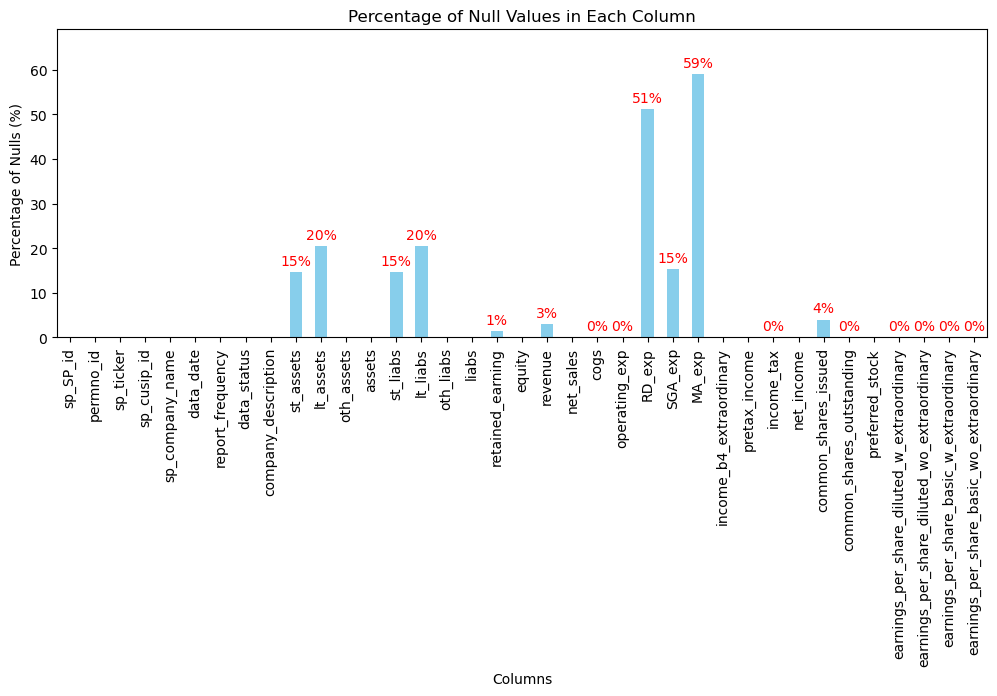

In [29]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## Investigate companies with missing retained_earning

permno == 11762, 52978, 42877, 17750, 79637, 15998, 16000, 14655, 13757,
       14811, 79996, 81481, 81472, 88362, 89927

In [30]:
df[df["retained_earning"].isnull()]["permno_id"].unique()

array([11762, 52978, 42877, 17750, 79637, 15998, 16000, 14655, 13757,
       14811, 79996, 81481, 81472, 88362, 89927])

## Investigate permno == 11762

In [31]:
permno = 11762

index_null = df[(df['permno_id'] == permno) & (df['retained_earning'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[-1] + 3)

df[(df["permno_id"] == permno) & (df["retained_earning"].isnull())][["assets", "liabs", "equity", "retained_earning"]]

,assets,liabs,equity,retained_earning
1779,32668.0,15367.0,17301.0,NaN
1780,31865.0,15140.0,16725.0,NaN
1781,31628.0,14839.0,16789.0,NaN


In [32]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
1777,REVVITY INC,2023-09-30,13421.548,5727.267,7694.281,5160.162,9.497
1778,REVVITY INC,2023-12-31,13564.665,5691.926,7872.739,5332.520,78.563
1779,EATON CORP PLC,2018-03-31,32668.000,15367.000,17301.000,NaN,488.000
1780,EATON CORP PLC,2018-06-30,31865.000,15140.000,16725.000,NaN,610.000
1781,EATON CORP PLC,2018-09-30,31628.000,14839.000,16789.000,NaN,416.000
1782,EATON CORP PLC,2018-12-31,31092.000,14950.000,16142.000,4016.000,631.000
1783,EATON CORP PLC,2019-03-31,31649.000,15382.000,16267.000,4147.000,522.000


### D1. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [33]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

In [34]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [35]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,EATON CORP PLC,2018-03-31,32668.0,15367.0,17301.0,2359.0,488.0
1,EATON CORP PLC,2018-06-30,31865.0,15140.0,16725.0,2969.0,610.0
2,EATON CORP PLC,2018-09-30,31628.0,14839.0,16789.0,3385.0,416.0
3,EATON CORP PLC,2018-12-31,31092.0,14950.0,16142.0,4016.0,631.0
4,EATON CORP PLC,2019-03-31,31649.0,15382.0,16267.0,4147.0,522.0
5,EATON CORP PLC,2019-06-30,32244.0,15883.0,16361.0,4192.0,636.0
6,EATON CORP PLC,2019-09-30,31895.0,15995.0,15900.0,3695.0,601.0
7,EATON CORP PLC,2019-12-31,32805.0,16672.0,16133.0,3880.0,452.0
8,EATON CORP PLC,2020-03-31,30845.0,16557.0,14288.0,2041.0,438.0
9,EATON CORP PLC,2020-06-30,30348.0,16113.0,14235.0,1958.0,51.0


In [36]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,4199,11762,ETN,G29183103,EATON CORP PLC,2018-03-31,Q,3,Eaton Corporation plc operates as a power mana...,8129.0,...,565.0,78.0,488.0,437.3,437.3,0.0,1.10,1.10,1.11,1.11
13374,4199,11762,ETN,G29183103,EATON CORP PLC,2018-06-30,Q,3,Eaton Corporation plc operates as a power mana...,7913.0,...,694.0,83.0,610.0,433.3,433.3,0.0,1.39,1.39,1.40,1.40
13375,4199,11762,ETN,G29183103,EATON CORP PLC,2018-09-30,Q,3,Eaton Corporation plc operates as a power mana...,7867.0,...,439.0,23.0,416.0,433.4,433.4,0.0,0.95,0.95,0.96,0.96
13376,4199,11762,ETN,G29183103,EATON CORP PLC,2018-12-31,Q,3,Eaton Corporation plc operates as a power mana...,7590.0,...,726.0,94.0,631.0,423.6,423.6,0.0,1.46,1.46,1.46,1.46
13377,4199,11762,ETN,G29183103,EATON CORP PLC,2019-03-31,Q,3,Eaton Corporation plc operates as a power mana...,7744.0,...,603.0,81.0,522.0,423.1,423.1,0.0,1.23,1.23,1.23,1.23
13378,4199,11762,ETN,G29183103,EATON CORP PLC,2019-06-30,Q,3,Eaton Corporation plc operates as a power mana...,8126.0,...,738.0,102.0,636.0,420.0,420.0,0.0,1.50,1.50,1.51,1.51
13379,4199,11762,ETN,G29183103,EATON CORP PLC,2019-09-30,Q,3,Eaton Corporation plc operates as a power mana...,8012.0,...,718.0,116.0,601.0,413.4,413.4,0.0,1.44,1.44,1.44,1.44
13380,4199,11762,ETN,G29183103,EATON CORP PLC,2019-12-31,Q,3,Eaton Corporation plc operates as a power mana...,8728.0,...,532.0,79.0,452.0,413.3,413.3,0.0,1.09,1.09,1.09,1.09
13381,4199,11762,ETN,G29183103,EATON CORP PLC,2020-03-31,Q,3,Eaton Corporation plc operates as a power mana...,8670.0,...,621.0,183.0,438.0,400.0,400.0,0.0,1.07,1.07,1.07,1.07
13382,4199,11762,ETN,G29183103,EATON CORP PLC,2020-06-30,Q,3,Eaton Corporation plc operates as a power mana...,8213.0,...,47.0,-7.0,51.0,400.1,400.1,0.0,0.13,0.13,0.13,0.13


## Investigate permno == 52978

In [37]:
permno = 52978

index_null = df[(df['permno_id'] == permno) & (df['retained_earning'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[-1] + 3)

df[(df["permno_id"] == permno) & (df["retained_earning"].isnull())][["assets", "liabs", "equity", "retained_earning"]]

,assets,liabs,equity,retained_earning
2473,8340.2,6117.0,2223.2,NaN


In [38]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
2471,HASBRO INC,2023-03-31,8923.700,6165.000,2758.700,3714.40,-22.100
2472,HASBRO INC,2023-06-30,8609.700,6139.500,2470.200,3404.60,-235.000
2473,HASBRO INC,2023-09-30,8340.200,6117.000,2223.200,NaN,-171.100
2474,HASBRO INC,2023-12-31,6540.900,5453.900,1087.000,1986.90,-1061.100
2475,WELLTOWER INC,2018-03-31,27746.659,12298.458,15059.326,-4132.44,449.347


### D2. Find the retained earning for the missing date from their 10-Q

https://investor.hasbro.com/node/36146/html

In [39]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2023-09-30"), 'retained_earning'] = 3348.3

In [40]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
2471,HASBRO INC,2023-03-31,8923.700,6165.000,2758.700,3714.40,-22.100
2472,HASBRO INC,2023-06-30,8609.700,6139.500,2470.200,3404.60,-235.000
2473,HASBRO INC,2023-09-30,8340.200,6117.000,2223.200,3348.30,-171.100
2474,HASBRO INC,2023-12-31,6540.900,5453.900,1087.000,1986.90,-1061.100
2475,WELLTOWER INC,2018-03-31,27746.659,12298.458,15059.326,-4132.44,449.347


## Investigate permno == 42877

In [41]:
permno = 42877

index_null = df[(df['permno_id'] == permno) & (df['retained_earning'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[-1] + 3)

df[(df["permno_id"] == permno) & (df["retained_earning"].isnull())][["assets", "liabs", "equity", "retained_earning"]]

,assets,liabs,equity,retained_earning
2667,4421.657,2478.594,1943.063,NaN
2668,4589.243,2555.881,2033.362,NaN
2669,4721.671,2641.093,2080.578,NaN


In [42]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
2665,CENTERPOINT ENERGY INC,2023-09-30,39001.000,29416.000,9585.000,998.000,282.000
2666,CENTERPOINT ENERGY INC,2023-12-31,39715.000,30048.000,9667.000,1057.000,192.000
2667,HUNT (JB) TRANSPRT SVCS INC,2018-03-31,4421.657,2478.594,1943.063,NaN,118.142
2668,HUNT (JB) TRANSPRT SVCS INC,2018-06-30,4589.243,2555.881,2033.362,NaN,151.652
2669,HUNT (JB) TRANSPRT SVCS INC,2018-09-30,4721.671,2641.093,2080.578,NaN,131.110
2670,HUNT (JB) TRANSPRT SVCS INC,2018-12-31,5091.647,2990.263,2101.384,4188.435,88.681
2671,HUNT (JB) TRANSPRT SVCS INC,2019-03-31,5327.282,3123.518,2203.764,4279.764,119.601


### D3. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [43]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

In [44]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [45]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,HUNT (JB) TRANSPRT SVCS INC,2018-03-31,4421.657,2478.594,1943.063,3816.992,118.142
1,HUNT (JB) TRANSPRT SVCS INC,2018-06-30,4589.243,2555.881,2033.362,3968.644,151.652
2,HUNT (JB) TRANSPRT SVCS INC,2018-09-30,4721.671,2641.093,2080.578,4099.754,131.110
3,HUNT (JB) TRANSPRT SVCS INC,2018-12-31,5091.647,2990.263,2101.384,4188.435,88.681
4,HUNT (JB) TRANSPRT SVCS INC,2019-03-31,5327.282,3123.518,2203.764,4279.764,119.601
5,HUNT (JB) TRANSPRT SVCS INC,2019-06-30,5420.739,3285.383,2135.356,4385.391,133.633
6,HUNT (JB) TRANSPRT SVCS INC,2019-09-30,5386.337,3192.808,2193.529,4475.992,118.410
7,HUNT (JB) TRANSPRT SVCS INC,2019-12-31,5470.854,3203.825,2267.029,4592.938,144.676
8,HUNT (JB) TRANSPRT SVCS INC,2020-03-31,5380.042,3097.624,2282.418,4669.084,104.834
9,HUNT (JB) TRANSPRT SVCS INC,2020-06-30,5553.632,3162.789,2390.843,4762.295,121.698


In [46]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2018-03-31,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1236.064,...,159.629,41.487,118.142,NaN,109.756,0.0,1.07,1.07,1.08,1.08
13374,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2018-06-30,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1307.421,...,204.957,53.305,151.652,NaN,109.344,0.0,1.37,1.37,1.39,1.39
13375,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2018-09-30,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1342.482,...,164.727,33.617,131.110,NaN,109.176,0.0,1.19,1.19,1.20,1.20
13376,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2018-12-31,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1502.981,...,111.505,22.824,88.681,167.099,108.711,0.0,0.81,0.81,0.81,0.81
13377,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2019-03-31,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1438.159,...,154.762,35.161,119.601,167.100,108.739,0.0,1.09,1.09,1.10,1.10
13378,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2019-06-30,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1384.364,...,178.330,44.697,133.633,167.100,106.768,0.0,1.23,1.23,1.24,1.24
13379,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2019-09-30,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1383.456,...,155.505,37.095,118.410,167.100,106.578,0.0,1.10,1.10,1.11,1.11
13380,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2019-12-31,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1481.299,...,192.298,47.622,144.676,167.099,106.213,0.0,1.35,1.35,1.36,1.36
13381,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2020-03-31,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1397.969,...,142.705,37.871,104.834,167.100,105.461,0.0,0.98,0.98,0.99,0.99
13382,5783,42877,JBHT,445658107,HUNT (JB) TRANSPRT SVCS INC,2020-06-30,Q,3,"J.B. Hunt Transport Services, Inc. provides su...",1544.697,...,162.365,40.667,121.698,167.100,105.507,0.0,1.14,1.14,1.15,1.15


## Investigate permno == 17750

In [47]:
permno = 17750

index_null = df[(df['permno_id'] == permno) & (df['retained_earning'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[-1] + 3)

df[(df["permno_id"] == permno) & (df["retained_earning"].isnull())][["assets", "liabs", "equity", "retained_earning"]]

,assets,liabs,equity,retained_earning
3046,15303.0,14687.0,555.0,NaN
3047,14564.0,14325.0,178.0,NaN
3048,14583.0,14410.0,112.0,NaN
3050,15204.0,15222.0,-82.0,NaN


In [48]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
3044,KELLANOVA,2023-09-30,18695.0,14418.0,4277.0,7555.0,271.0
3045,KELLANOVA,2023-12-31,15621.0,12252.0,3369.0,6763.0,27.0
3046,KIMBERLY-CLARK CORP,2018-03-31,15303.0,14687.0,555.0,NaN,93.0
3047,KIMBERLY-CLARK CORP,2018-06-30,14564.0,14325.0,178.0,NaN,455.0
3048,KIMBERLY-CLARK CORP,2018-09-30,14583.0,14410.0,112.0,NaN,451.0
3049,KIMBERLY-CLARK CORP,2018-12-31,14518.0,14500.0,-46.0,2648.0,411.0
3050,KIMBERLY-CLARK CORP,2019-03-31,15204.0,15222.0,-82.0,NaN,454.0
3051,KIMBERLY-CLARK CORP,2019-06-30,15347.0,15259.0,50.0,2901.0,485.0
3052,KIMBERLY-CLARK CORP,2019-09-30,15033.0,14907.0,88.0,3073.0,671.0


### D4. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [49]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

In [50]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [51]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,KIMBERLY-CLARK CORP,2018-03-31,15303.0,14687.0,555.0,1331.0,93.0
1,KIMBERLY-CLARK CORP,2018-06-30,14564.0,14325.0,178.0,1786.0,455.0
2,KIMBERLY-CLARK CORP,2018-09-30,14583.0,14410.0,112.0,2237.0,451.0
3,KIMBERLY-CLARK CORP,2018-12-31,14518.0,14500.0,-46.0,2648.0,411.0
4,KIMBERLY-CLARK CORP,2019-03-31,15204.0,15222.0,-82.0,2416.0,454.0
5,KIMBERLY-CLARK CORP,2019-06-30,15347.0,15259.0,50.0,2901.0,485.0
6,KIMBERLY-CLARK CORP,2019-09-30,15033.0,14907.0,88.0,3073.0,671.0
7,KIMBERLY-CLARK CORP,2019-12-31,15283.0,15060.0,194.0,3392.0,547.0
8,KIMBERLY-CLARK CORP,2020-03-31,15677.0,15602.0,46.0,3363.0,660.0
9,KIMBERLY-CLARK CORP,2020-06-30,16173.0,15649.0,495.0,3786.0,681.0


In [52]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2018-03-31,Q,3,"Kimberly-Clark Corporation, together with its ...",5372.0,...,201.0,104.0,93.0,NaN,349.600,0.0,0.26,0.26,0.27,0.27
13374,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2018-06-30,Q,3,"Kimberly-Clark Corporation, together with its ...",5028.0,...,603.0,138.0,455.0,NaN,347.900,0.0,1.30,1.30,1.30,1.30
13375,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2018-09-30,Q,3,"Kimberly-Clark Corporation, together with its ...",5108.0,...,600.0,138.0,451.0,NaN,346.600,0.0,1.29,1.29,1.30,1.30
13376,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2018-12-31,Q,3,"Kimberly-Clark Corporation, together with its ...",5041.0,...,512.0,91.0,411.0,378.597,344.962,0.0,1.18,1.18,1.19,1.19
13377,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2019-03-31,Q,3,"Kimberly-Clark Corporation, together with its ...",5255.0,...,609.0,143.0,454.0,NaN,343.900,0.0,1.31,1.31,1.32,1.32
13378,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2019-06-30,Q,3,"Kimberly-Clark Corporation, together with its ...",5321.0,...,627.0,132.0,485.0,378.597,344.216,0.0,1.40,1.40,1.41,1.41
13379,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2019-09-30,Q,3,"Kimberly-Clark Corporation, together with its ...",5064.0,...,872.0,192.0,671.0,378.597,343.137,0.0,1.94,1.94,1.95,1.95
13380,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2019-12-31,Q,3,"Kimberly-Clark Corporation, together with its ...",5057.0,...,665.0,109.0,547.0,378.597,341.448,0.0,1.59,1.59,1.60,1.60
13381,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2020-03-31,Q,3,"Kimberly-Clark Corporation, together with its ...",5646.0,...,872.0,197.0,660.0,378.597,340.836,0.0,1.92,1.92,1.93,1.93
13382,6435,17750,KMB,494368103,KIMBERLY-CLARK CORP,2020-06-30,Q,3,"Kimberly-Clark Corporation, together with its ...",5904.0,...,891.0,199.0,681.0,378.597,341.023,0.0,1.99,1.99,2.00,2.00


## Investigate permno == 79637

In [53]:
permno = 79637

index_null = df[(df['permno_id'] == permno) & (df['retained_earning'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[-1] + 3)

df[(df["permno_id"] == permno) & (df["retained_earning"].isnull())][["assets", "liabs", "equity", "retained_earning"]]

,assets,liabs,equity,retained_earning
5310,11023.517,5731.414,5286.022,NaN
5311,11069.417,5672.866,5390.210,NaN
5312,11273.585,5828.066,5439.130,NaN


In [54]:
df.iloc[beg:end][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
5308,RTX CORP,2023-09-30,162443.000,91197.000,71213.000,49397.000,-984.000
5309,RTX CORP,2023-12-31,161869.000,100424.000,61410.000,49735.000,1426.000
5310,UNIVERSAL HEALTH SVCS INC,2018-03-31,11023.517,5731.414,5286.022,NaN,223.832
5311,UNIVERSAL HEALTH SVCS INC,2018-06-30,11069.417,5672.866,5390.210,NaN,226.052
5312,UNIVERSAL HEALTH SVCS INC,2018-09-30,11273.585,5828.066,5439.130,NaN,171.746
5313,UNIVERSAL HEALTH SVCS INC,2018-12-31,11265.480,5795.395,5465.793,5388.348,158.075
5314,UNIVERSAL HEALTH SVCS INC,2019-03-31,11721.277,6165.123,5552.311,5481.505,234.168


### D5. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [55]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

In [56]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [57]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,UNIVERSAL HEALTH SVCS INC,2018-03-31,11023.517,5731.414,5286.022,4832.475,223.832
1,UNIVERSAL HEALTH SVCS INC,2018-06-30,11069.417,5672.866,5390.210,5058.527,226.052
2,UNIVERSAL HEALTH SVCS INC,2018-09-30,11273.585,5828.066,5439.130,5230.273,171.746
3,UNIVERSAL HEALTH SVCS INC,2018-12-31,11265.480,5795.395,5465.793,5388.348,158.075
4,UNIVERSAL HEALTH SVCS INC,2019-03-31,11721.277,6165.123,5552.311,5481.505,234.168
5,UNIVERSAL HEALTH SVCS INC,2019-06-30,11752.650,6284.213,5464.451,5392.206,238.320
6,UNIVERSAL HEALTH SVCS INC,2019-09-30,11594.401,6126.395,5463.945,5388.335,97.190
7,UNIVERSAL HEALTH SVCS INC,2019-12-31,11668.250,6085.046,5578.871,5503.238,245.176
8,UNIVERSAL HEALTH SVCS INC,2020-03-31,11620.426,6131.430,5485.043,5412.360,142.037
9,UNIVERSAL HEALTH SVCS INC,2020-06-30,12148.499,6382.640,5761.572,5687.797,251.929


In [58]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2018-03-31,Q,3,"Universal Health Services, Inc., through its s...",1884.726,...,296.238,67.569,223.832,94.407,94.407,0.0,2.36,2.36,2.37,2.37
13374,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2018-06-30,Q,3,"Universal Health Services, Inc., through its s...",1880.527,...,301.770,71.059,226.052,93.346,93.346,0.0,2.39,2.39,2.40,2.40
13375,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2018-09-30,Q,3,"Universal Health Services, Inc., through its s...",1941.253,...,229.067,54.186,171.746,92.513,92.513,0.0,1.84,1.84,1.85,1.85
13376,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2018-12-31,Q,3,"Universal Health Services, Inc., through its s...",1937.802,...,207.450,43.828,158.075,91.350,91.350,0.0,1.70,1.70,1.71,1.71
13377,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2019-03-31,Q,3,"Universal Health Services, Inc., through its s...",1960.441,...,296.296,58.898,234.168,90.141,90.141,0.0,2.57,2.57,2.57,2.57
13378,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2019-06-30,Q,3,"Universal Health Services, Inc., through its s...",1965.032,...,310.808,69.543,238.320,88.490,88.490,0.0,2.66,2.66,2.67,2.67
13379,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2019-09-30,Q,3,"Universal Health Services, Inc., through its s...",1930.627,...,138.075,37.205,97.190,87.582,87.582,0.0,1.10,1.10,1.10,1.10
13380,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2019-12-31,Q,3,"Universal Health Services, Inc., through its s...",1915.934,...,321.158,73.148,245.176,86.706,86.706,0.0,2.79,2.79,2.81,2.81
13381,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2020-03-31,Q,3,"Universal Health Services, Inc., through its s...",1834.346,...,190.783,46.323,142.037,84.926,84.926,0.0,1.64,1.64,1.64,1.64
13382,11032,79637,UHS,913903100,UNIVERSAL HEALTH SVCS INC,2020-06-30,Q,3,"Universal Health Services, Inc., through its s...",2296.787,...,335.658,79.154,251.929,84.958,84.958,0.0,2.95,2.95,2.97,2.97


## Investigate permno == 15998

In [59]:
permno = 15998

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
6627,LIBERTY MEDIA SIRIUSXM GROUP,2018-03-31,28958.0,12523.0,16435.0,NaN
6629,LIBERTY MEDIA SIRIUSXM GROUP,2018-06-30,28514.0,12080.0,16434.0,NaN
6631,LIBERTY MEDIA SIRIUSXM GROUP,2018-09-30,28476.0,12215.0,16261.0,NaN
6633,LIBERTY MEDIA SIRIUSXM GROUP,2018-12-31,28292.0,12585.0,15707.0,NaN
6635,LIBERTY MEDIA SIRIUSXM GROUP,2019-03-31,31373.0,13943.0,17430.0,NaN
6637,LIBERTY MEDIA SIRIUSXM GROUP,2019-06-30,31162.0,14430.0,16732.0,NaN
6639,LIBERTY MEDIA SIRIUSXM GROUP,2019-09-30,31004.0,14603.0,16401.0,NaN
6641,LIBERTY MEDIA SIRIUSXM GROUP,2019-12-31,31421.0,15115.0,16306.0,NaN
6643,LIBERTY MEDIA SIRIUSXM GROUP,2020-03-31,31108.0,14831.0,16277.0,NaN
6645,LIBERTY MEDIA SIRIUSXM GROUP,2020-06-30,33499.0,18394.0,15105.0,NaN


### D6. All retained earnings are missing from this company, it would be too much work to look through the filing one-by-one manually, we will use the equity as an approximate for the retained earnings, based on a sample 10-Q the company does not have significant APIC compared to their retained earnings.

In [60]:
df.loc[(df['permno_id'] == permno) & (df['retained_earning'].isnull()), 'retained_earning'] = df['equity']

In [61]:
df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
6627,LIBERTY MEDIA SIRIUSXM GROUP,2018-03-31,28958.0,12523.0,16435.0,16435.0
6629,LIBERTY MEDIA SIRIUSXM GROUP,2018-06-30,28514.0,12080.0,16434.0,16434.0
6631,LIBERTY MEDIA SIRIUSXM GROUP,2018-09-30,28476.0,12215.0,16261.0,16261.0
6633,LIBERTY MEDIA SIRIUSXM GROUP,2018-12-31,28292.0,12585.0,15707.0,15707.0
6635,LIBERTY MEDIA SIRIUSXM GROUP,2019-03-31,31373.0,13943.0,17430.0,17430.0
6637,LIBERTY MEDIA SIRIUSXM GROUP,2019-06-30,31162.0,14430.0,16732.0,16732.0
6639,LIBERTY MEDIA SIRIUSXM GROUP,2019-09-30,31004.0,14603.0,16401.0,16401.0
6641,LIBERTY MEDIA SIRIUSXM GROUP,2019-12-31,31421.0,15115.0,16306.0,16306.0
6643,LIBERTY MEDIA SIRIUSXM GROUP,2020-03-31,31108.0,14831.0,16277.0,16277.0
6645,LIBERTY MEDIA SIRIUSXM GROUP,2020-06-30,33499.0,18394.0,15105.0,15105.0


## Investigate permno == 16000

In [62]:
permno = 16000

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
6628,LIBERTY MEDIA SIRIUSXM GROUP,2018-03-31,28958.0,12523.0,16435.0,NaN
6630,LIBERTY MEDIA SIRIUSXM GROUP,2018-06-30,28514.0,12080.0,16434.0,NaN
6632,LIBERTY MEDIA SIRIUSXM GROUP,2018-09-30,28476.0,12215.0,16261.0,NaN
6634,LIBERTY MEDIA SIRIUSXM GROUP,2018-12-31,28292.0,12585.0,15707.0,NaN
6636,LIBERTY MEDIA SIRIUSXM GROUP,2019-03-31,31373.0,13943.0,17430.0,NaN
6638,LIBERTY MEDIA SIRIUSXM GROUP,2019-06-30,31162.0,14430.0,16732.0,NaN
6640,LIBERTY MEDIA SIRIUSXM GROUP,2019-09-30,31004.0,14603.0,16401.0,NaN
6642,LIBERTY MEDIA SIRIUSXM GROUP,2019-12-31,31421.0,15115.0,16306.0,NaN
6644,LIBERTY MEDIA SIRIUSXM GROUP,2020-03-31,31108.0,14831.0,16277.0,NaN
6646,LIBERTY MEDIA SIRIUSXM GROUP,2020-06-30,33499.0,18394.0,15105.0,NaN


### D7. All retained earnings are missing from this company, it would be too much work to look through the filing one-by-one manually, we will use the equity as an approximate for the retained earnings, based on a sample 10-Q the company does not have significant APIC compared to their retained earnings.

In [63]:
df.loc[(df['permno_id'] == permno) & (df['retained_earning'].isnull()), 'retained_earning'] = df['equity']

In [64]:
df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
6628,LIBERTY MEDIA SIRIUSXM GROUP,2018-03-31,28958.0,12523.0,16435.0,16435.0
6630,LIBERTY MEDIA SIRIUSXM GROUP,2018-06-30,28514.0,12080.0,16434.0,16434.0
6632,LIBERTY MEDIA SIRIUSXM GROUP,2018-09-30,28476.0,12215.0,16261.0,16261.0
6634,LIBERTY MEDIA SIRIUSXM GROUP,2018-12-31,28292.0,12585.0,15707.0,15707.0
6636,LIBERTY MEDIA SIRIUSXM GROUP,2019-03-31,31373.0,13943.0,17430.0,17430.0
6638,LIBERTY MEDIA SIRIUSXM GROUP,2019-06-30,31162.0,14430.0,16732.0,16732.0
6640,LIBERTY MEDIA SIRIUSXM GROUP,2019-09-30,31004.0,14603.0,16401.0,16401.0
6642,LIBERTY MEDIA SIRIUSXM GROUP,2019-12-31,31421.0,15115.0,16306.0,16306.0
6644,LIBERTY MEDIA SIRIUSXM GROUP,2020-03-31,31108.0,14831.0,16277.0,16277.0
6646,LIBERTY MEDIA SIRIUSXM GROUP,2020-06-30,33499.0,18394.0,15105.0,15105.0


## Investigate permno == 14655

In [65]:
permno = 14655

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
6795,JD.COM INC,2018-03-31,29543.453,18552.087,8712.665,NaN,243.111
6796,JD.COM INC,2018-06-30,33030.124,21942.600,8899.438,NaN,-346.977
6797,JD.COM INC,2018-09-30,31088.781,19423.640,9391.514,NaN,440.625
6798,JD.COM INC,2018-12-31,30411.441,19241.044,8849.713,-2803.001,-699.029
6799,JD.COM INC,2019-03-31,31934.899,19461.874,10094.690,NaN,1090.547
6800,JD.COM INC,2019-06-30,35748.513,22931.507,10492.497,NaN,65.380
6801,JD.COM INC,2019-09-30,34393.049,21281.516,10878.152,NaN,40.286
6802,JD.COM INC,2019-12-31,37300.534,22849.263,12158.526,-903.399,553.629
6803,JD.COM INC,2020-03-31,37523.408,22942.534,12326.162,-632.451,151.511
6804,JD.COM INC,2020-06-30,49890.366,27809.494,19821.037,NaN,2328.205


### D8. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [66]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [67]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,JD.COM INC,2018-03-31,29543.453,18552.087,8712.665,NaN,243.111
1,JD.COM INC,2018-06-30,33030.124,21942.600,8899.438,NaN,-346.977
2,JD.COM INC,2018-09-30,31088.781,19423.640,9391.514,NaN,440.625
3,JD.COM INC,2018-12-31,30411.441,19241.044,8849.713,-2803.001,-699.029
4,JD.COM INC,2019-03-31,31934.899,19461.874,10094.690,-1712.454,1090.547
5,JD.COM INC,2019-06-30,35748.513,22931.507,10492.497,-1647.074,65.380
6,JD.COM INC,2019-09-30,34393.049,21281.516,10878.152,-1606.788,40.286
7,JD.COM INC,2019-12-31,37300.534,22849.263,12158.526,-903.399,553.629
8,JD.COM INC,2020-03-31,37523.408,22942.534,12326.162,-632.451,151.511
9,JD.COM INC,2020-06-30,49890.366,27809.494,19821.037,1695.754,2328.205


### D9. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [68]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [69]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,JD.COM INC,2018-03-31,29543.453,18552.087,8712.665,-2197.620,243.111
1,JD.COM INC,2018-06-30,33030.124,21942.600,8899.438,-2544.597,-346.977
2,JD.COM INC,2018-09-30,31088.781,19423.640,9391.514,-2103.972,440.625
3,JD.COM INC,2018-12-31,30411.441,19241.044,8849.713,-2803.001,-699.029
4,JD.COM INC,2019-03-31,31934.899,19461.874,10094.690,-1712.454,1090.547
5,JD.COM INC,2019-06-30,35748.513,22931.507,10492.497,-1647.074,65.380
6,JD.COM INC,2019-09-30,34393.049,21281.516,10878.152,-1606.788,40.286
7,JD.COM INC,2019-12-31,37300.534,22849.263,12158.526,-903.399,553.629
8,JD.COM INC,2020-03-31,37523.408,22942.534,12326.162,-632.451,151.511
9,JD.COM INC,2020-06-30,49890.366,27809.494,19821.037,1695.754,2328.205


In [70]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,19744,14655,JD,47215P106,JD.COM INC,2018-03-31,Q,3,"JD.com, Inc. operates as a supply chain-based ...",18014.172,...,259.584,24.076,243.111,1469.355,1427.227,0.0,0.17,0.17,0.17,0.17
13374,19744,14655,JD,47215P106,JD.COM INC,2018-06-30,Q,3,"JD.com, Inc. operates as a supply chain-based ...",19909.599,...,-332.941,23.413,-346.977,1482.908,1446.268,0.0,-0.24,-0.24,-0.24,-0.24
13375,19744,14655,JD,47215P106,JD.COM INC,2018-09-30,Q,3,"JD.com, Inc. operates as a supply chain-based ...",15946.874,...,429.005,5.782,440.625,1482.908,1446.783,0.0,0.30,0.30,0.30,0.30
13376,19744,14655,JD,47215P106,JD.COM INC,2018-12-31,Q,3,"JD.com, Inc. operates as a supply chain-based ...",15245.464,...,-700.768,8.794,-699.029,1482.908,1447.148,0.0,-0.48,-0.48,-0.48,-0.48
13377,19744,14655,JD,47215P106,JD.COM INC,2019-03-31,Q,3,"JD.com, Inc. operates as a supply chain-based ...",14165.102,...,1120.374,41.666,1090.547,1482.908,1447.524,0.0,0.74,0.74,0.75,0.75
13378,19744,14655,JD,47215P106,JD.COM INC,2019-06-30,Q,3,"JD.com, Inc. operates as a supply chain-based ...",18560.281,...,117.983,62.955,65.380,1486.972,1458.871,0.0,0.05,0.05,0.05,0.05
13379,19744,14655,JD,47215P106,JD.COM INC,2019-09-30,Q,3,"JD.com, Inc. operates as a supply chain-based ...",18132.101,...,113.060,80.515,40.286,1486.972,1460.161,0.0,0.03,0.03,0.03,0.03
13380,19744,14655,JD,47215P106,JD.COM INC,2019-12-31,Q,3,"JD.com, Inc. operates as a supply chain-based ...",19976.233,...,615.053,73.724,553.629,1486.972,1462.158,0.0,0.37,0.37,0.38,0.38
13381,19744,14655,JD,47215P106,JD.COM INC,2020-03-31,Q,3,"JD.com, Inc. operates as a supply chain-based ...",20414.654,...,195.405,46.103,151.511,1486.972,1463.166,0.0,0.10,0.10,0.10,0.10
13382,19744,14655,JD,47215P106,JD.COM INC,2020-06-30,Q,3,"JD.com, Inc. operates as a supply chain-based ...",29083.334,...,2436.292,112.846,2328.205,1554.941,1538.951,0.0,1.51,1.51,1.58,1.58


## Investigate permno == 13757

In [71]:
permno = 13757

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
7864,LIBERTY MEDIA FORMULA ONE,2018-03-31,11842.0,6184.0,5658.0,NaN
7867,LIBERTY MEDIA FORMULA ONE,2018-06-30,11589.0,5939.0,5650.0,NaN
7869,LIBERTY MEDIA FORMULA ONE,2018-09-30,11483.0,5797.0,5686.0,NaN
7871,LIBERTY MEDIA FORMULA ONE,2018-12-31,10957.0,5404.0,5553.0,NaN
7873,LIBERTY MEDIA FORMULA ONE,2019-03-31,11367.0,5972.0,5395.0,NaN
7875,LIBERTY MEDIA FORMULA ONE,2019-06-30,11298.0,5952.0,5346.0,NaN
7877,LIBERTY MEDIA FORMULA ONE,2019-09-30,11361.0,6002.0,5359.0,NaN
7879,LIBERTY MEDIA FORMULA ONE,2019-12-31,11505.0,6264.0,5241.0,NaN
7881,LIBERTY MEDIA FORMULA ONE,2020-03-31,11362.0,6364.0,4998.0,NaN
7883,LIBERTY MEDIA FORMULA ONE,2020-06-30,11583.0,4967.0,6616.0,NaN


### D10. All retained earnings are missing from this company, it would be too much work to look through the filing one-by-one manually, we will use the equity as an approximate for the retained earnings, based on a sample 10-Q the company does not have significant APIC compared to their retained earnings.

In [72]:
df.loc[(df['permno_id'] == permno) & (df['retained_earning'].isnull()), 'retained_earning'] = df['equity']

In [73]:
df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
7864,LIBERTY MEDIA FORMULA ONE,2018-03-31,11842.0,6184.0,5658.0,5658.0
7867,LIBERTY MEDIA FORMULA ONE,2018-06-30,11589.0,5939.0,5650.0,5650.0
7869,LIBERTY MEDIA FORMULA ONE,2018-09-30,11483.0,5797.0,5686.0,5686.0
7871,LIBERTY MEDIA FORMULA ONE,2018-12-31,10957.0,5404.0,5553.0,5553.0
7873,LIBERTY MEDIA FORMULA ONE,2019-03-31,11367.0,5972.0,5395.0,5395.0
7875,LIBERTY MEDIA FORMULA ONE,2019-06-30,11298.0,5952.0,5346.0,5346.0
7877,LIBERTY MEDIA FORMULA ONE,2019-09-30,11361.0,6002.0,5359.0,5359.0
7879,LIBERTY MEDIA FORMULA ONE,2019-12-31,11505.0,6264.0,5241.0,5241.0
7881,LIBERTY MEDIA FORMULA ONE,2020-03-31,11362.0,6364.0,4998.0,4998.0
7883,LIBERTY MEDIA FORMULA ONE,2020-06-30,11583.0,4967.0,6616.0,6616.0


## Investigate permno == 14811

In [74]:
permno = 14811

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
7865,LIBERTY MEDIA FORMULA ONE,2018-03-31,11842.0,6184.0,5658.0,NaN,-17.0
7866,LIBERTY MEDIA FORMULA ONE,2018-06-30,11589.0,5939.0,5650.0,NaN,9.0
7868,LIBERTY MEDIA FORMULA ONE,2018-09-30,11483.0,5797.0,5686.0,NaN,42.0
7870,LIBERTY MEDIA FORMULA ONE,2018-12-31,10957.0,5404.0,5553.0,NaN,-184.0
7872,LIBERTY MEDIA FORMULA ONE,2019-03-31,11367.0,5972.0,5395.0,NaN,-148.0
7874,LIBERTY MEDIA FORMULA ONE,2019-06-30,11298.0,5952.0,5346.0,NaN,-77.0
7876,LIBERTY MEDIA FORMULA ONE,2019-09-30,11361.0,6002.0,5359.0,NaN,41.0
7878,LIBERTY MEDIA FORMULA ONE,2019-12-31,11505.0,6264.0,5241.0,NaN,-127.0
7880,LIBERTY MEDIA FORMULA ONE,2020-03-31,11362.0,6364.0,4998.0,NaN,-343.0
7882,LIBERTY MEDIA FORMULA ONE,2020-06-30,11583.0,4967.0,6616.0,NaN,-200.0


### D11. All retained earnings are missing from this company, it would be too much work to look through the filing one-by-one manually, we will use the equity as an approximate for the retained earnings, based on a sample 10-Q the company does not have significant APIC compared to their retained earnings.

In [75]:
df.loc[(df['permno_id'] == permno) & (df['retained_earning'].isnull()), 'retained_earning'] = df['equity']

In [76]:
df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning
7865,LIBERTY MEDIA FORMULA ONE,2018-03-31,11842.0,6184.0,5658.0,5658.0
7866,LIBERTY MEDIA FORMULA ONE,2018-06-30,11589.0,5939.0,5650.0,5650.0
7868,LIBERTY MEDIA FORMULA ONE,2018-09-30,11483.0,5797.0,5686.0,5686.0
7870,LIBERTY MEDIA FORMULA ONE,2018-12-31,10957.0,5404.0,5553.0,5553.0
7872,LIBERTY MEDIA FORMULA ONE,2019-03-31,11367.0,5972.0,5395.0,5395.0
7874,LIBERTY MEDIA FORMULA ONE,2019-06-30,11298.0,5952.0,5346.0,5346.0
7876,LIBERTY MEDIA FORMULA ONE,2019-09-30,11361.0,6002.0,5359.0,5359.0
7878,LIBERTY MEDIA FORMULA ONE,2019-12-31,11505.0,6264.0,5241.0,5241.0
7880,LIBERTY MEDIA FORMULA ONE,2020-03-31,11362.0,6364.0,4998.0,4998.0
7882,LIBERTY MEDIA FORMULA ONE,2020-06-30,11583.0,4967.0,6616.0,6616.0


## Investigate permno == 79996

In [77]:
permno = 79996

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
8715,MILLICOM INTL CELLULAR SA,2019-03-31,11356.0,8535.0,2821.0,NaN,14.0
8716,MILLICOM INTL CELLULAR SA,2019-06-30,11676.0,9081.0,2595.0,NaN,45.0
8717,MILLICOM INTL CELLULAR SA,2019-09-30,11942.0,9543.0,2399.0,NaN,-133.0
8718,MILLICOM INTL CELLULAR SA,2019-12-31,12856.0,10176.0,2680.0,1828.0,223.0
8719,MILLICOM INTL CELLULAR SA,2020-03-31,12697.0,10296.0,2401.0,NaN,-122.0
8720,MILLICOM INTL CELLULAR SA,2020-06-30,12552.0,10227.0,2325.0,NaN,-116.0
8721,MILLICOM INTL CELLULAR SA,2020-09-30,12330.0,10064.0,2266.0,NaN,-51.0
8722,MILLICOM INTL CELLULAR SA,2020-12-31,12422.0,10148.0,2274.0,1458.0,-55.0
8723,MILLICOM INTL CELLULAR SA,2021-03-31,11788.0,9543.0,2245.0,NaN,42.0
8724,MILLICOM INTL CELLULAR SA,2021-06-30,11506.0,9338.0,2168.0,NaN,-100.0


### D12. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [78]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [79]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,MILLICOM INTL CELLULAR SA,2019-03-31,11356.0,8535.0,2821.0,NaN,14.0
1,MILLICOM INTL CELLULAR SA,2019-06-30,11676.0,9081.0,2595.0,NaN,45.0
2,MILLICOM INTL CELLULAR SA,2019-09-30,11942.0,9543.0,2399.0,NaN,-133.0
3,MILLICOM INTL CELLULAR SA,2019-12-31,12856.0,10176.0,2680.0,1828.0,223.0
4,MILLICOM INTL CELLULAR SA,2020-03-31,12697.0,10296.0,2401.0,1706.0,-122.0
5,MILLICOM INTL CELLULAR SA,2020-06-30,12552.0,10227.0,2325.0,1590.0,-116.0
6,MILLICOM INTL CELLULAR SA,2020-09-30,12330.0,10064.0,2266.0,1539.0,-51.0
7,MILLICOM INTL CELLULAR SA,2020-12-31,12422.0,10148.0,2274.0,1458.0,-55.0
8,MILLICOM INTL CELLULAR SA,2021-03-31,11788.0,9543.0,2245.0,1500.0,42.0
9,MILLICOM INTL CELLULAR SA,2021-06-30,11506.0,9338.0,2168.0,1400.0,-100.0


### D13. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [80]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [81]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,MILLICOM INTL CELLULAR SA,2019-03-31,11356.0,8535.0,2821.0,1693.0,14.0
1,MILLICOM INTL CELLULAR SA,2019-06-30,11676.0,9081.0,2595.0,1738.0,45.0
2,MILLICOM INTL CELLULAR SA,2019-09-30,11942.0,9543.0,2399.0,1605.0,-133.0
3,MILLICOM INTL CELLULAR SA,2019-12-31,12856.0,10176.0,2680.0,1828.0,223.0
4,MILLICOM INTL CELLULAR SA,2020-03-31,12697.0,10296.0,2401.0,1706.0,-122.0
5,MILLICOM INTL CELLULAR SA,2020-06-30,12552.0,10227.0,2325.0,1590.0,-116.0
6,MILLICOM INTL CELLULAR SA,2020-09-30,12330.0,10064.0,2266.0,1539.0,-51.0
7,MILLICOM INTL CELLULAR SA,2020-12-31,12422.0,10148.0,2274.0,1458.0,-55.0
8,MILLICOM INTL CELLULAR SA,2021-03-31,11788.0,9543.0,2245.0,1500.0,42.0
9,MILLICOM INTL CELLULAR SA,2021-06-30,11506.0,9338.0,2168.0,1400.0,-100.0


In [82]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13377,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2019-03-31,Q,3,Millicom International Cellular S.A. provides ...,2163.0,...,44.0,19.0,14.0,101.739,101.089,0.0,0.14,0.14,0.14,0.14
13378,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2019-06-30,Q,3,Millicom International Cellular S.A. provides ...,2073.0,...,-8.0,22.0,45.0,101.739,101.123,0.0,0.44,-0.20,0.44,-0.20
13379,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2019-09-30,Q,3,Millicom International Cellular S.A. provides ...,1806.0,...,-95.0,49.0,-133.0,101.739,101.143,0.0,-1.30,-1.27,-1.30,-1.27
13380,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2019-12-31,Q,3,Millicom International Cellular S.A. provides ...,2646.0,...,277.0,31.0,223.0,101.739,101.159,0.0,2.20,2.23,2.20,2.23
13381,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2020-03-31,Q,3,Millicom International Cellular S.A. provides ...,2966.0,...,-167.0,-16.0,-122.0,101.739,101.077,0.0,-1.21,-1.21,-1.21,-1.21
13382,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2020-06-30,Q,3,Millicom International Cellular S.A. provides ...,2539.0,...,-53.0,65.0,-116.0,101.739,101.176,0.0,-1.14,-1.13,-1.14,-1.13
13383,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2020-09-30,Q,3,Millicom International Cellular S.A. provides ...,2500.0,...,-52.0,-1.0,-51.0,101.739,101.213,0.0,-0.50,-0.42,-0.50,-0.42
13384,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2020-12-31,Q,3,Millicom International Cellular S.A. provides ...,2308.0,...,1.0,54.0,-55.0,101.739,101.213,0.0,-0.55,-0.52,-0.55,-0.52
13385,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2021-03-31,Q,3,Millicom International Cellular S.A. provides ...,1968.0,...,30.0,21.0,42.0,101.739,101.533,0.0,0.41,0.26,0.41,0.26
13386,30024,79996,TIGO,L6388F110,MILLICOM INTL CELLULAR SA,2021-06-30,Q,3,Millicom International Cellular S.A. provides ...,1959.0,...,-68.0,33.0,-100.0,101.739,101.560,0.0,-0.98,-0.92,-0.98,-0.92


## Investigate permno == 81481

In [83]:
permno = 81481

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
8883,DOLLAR TREE INC,2018-01-31,16332.8,9150.5,7182.3,4634.6,1040.1
8884,DOLLAR TREE INC,2018-04-30,15827.1,8471.4,7355.7,4791.2,160.5
8885,DOLLAR TREE INC,2018-07-31,16103.6,8456.1,7647.5,NaN,273.9
8886,DOLLAR TREE INC,2018-10-31,16649.3,8706.2,7943.1,NaN,281.8
8887,DOLLAR TREE INC,2019-01-31,13501.2,7858.3,5642.9,3037.8,-2307.0
8888,DOLLAR TREE INC,2019-04-30,19354.3,13598.4,5755.9,3237.6,267.9
8889,DOLLAR TREE INC,2019-07-31,19493.8,13628.1,5865.7,3419.4,180.3
8890,DOLLAR TREE INC,2019-10-31,19742.1,13620.8,6121.3,3675.6,255.8
8891,DOLLAR TREE INC,2020-01-31,19574.6,13319.8,6254.8,3798.0,123.0
8892,DOLLAR TREE INC,2020-04-30,20471.8,13951.2,6520.6,4037.6,247.6


### D14. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [84]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [85]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,DOLLAR TREE INC,2018-01-31,16332.8,9150.5,7182.3,4634.6,1040.1
1,DOLLAR TREE INC,2018-04-30,15827.1,8471.4,7355.7,4791.2,160.5
2,DOLLAR TREE INC,2018-07-31,16103.6,8456.1,7647.5,5065.1,273.9
3,DOLLAR TREE INC,2018-10-31,16649.3,8706.2,7943.1,5346.9,281.8
4,DOLLAR TREE INC,2019-01-31,13501.2,7858.3,5642.9,3037.8,-2307.0
5,DOLLAR TREE INC,2019-04-30,19354.3,13598.4,5755.9,3237.6,267.9
6,DOLLAR TREE INC,2019-07-31,19493.8,13628.1,5865.7,3419.4,180.3
7,DOLLAR TREE INC,2019-10-31,19742.1,13620.8,6121.3,3675.6,255.8
8,DOLLAR TREE INC,2020-01-31,19574.6,13319.8,6254.8,3798.0,123.0
9,DOLLAR TREE INC,2020-04-30,20471.8,13951.2,6520.6,4037.6,247.6


In [86]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,31587,81481,DLTR,256746108,DOLLAR TREE INC,2018-01-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4576.3,...,691.5,-348.6,1040.1,237.326,237.326,0.0,4.37,4.37,4.38,4.38
13374,31587,81481,DLTR,256746108,DOLLAR TREE INC,2018-04-30,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4042.0,...,207.4,46.9,160.5,237.800,237.800,0.0,0.67,0.67,0.68,0.68
13375,31587,81481,DLTR,256746108,DOLLAR TREE INC,2018-07-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4272.8,...,337.7,63.8,273.9,237.900,237.900,0.0,1.15,1.15,1.15,1.15
13376,31587,81481,DLTR,256746108,DOLLAR TREE INC,2018-10-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4749.5,...,340.0,58.2,281.8,238.000,238.000,0.0,1.18,1.18,1.18,1.18
13377,31587,81481,DLTR,256746108,DOLLAR TREE INC,2019-01-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4293.3,...,-2194.1,112.9,-2307.0,238.082,238.082,0.0,-9.66,-9.66,-9.69,-9.69
13378,31587,81481,DLTR,256746108,DOLLAR TREE INC,2019-04-30,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4246.1,...,343.9,76.0,267.9,237.600,237.600,0.0,1.12,1.12,1.13,1.13
13379,31587,81481,DLTR,256746108,DOLLAR TREE INC,2019-07-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4340.8,...,228.4,48.1,180.3,236.800,236.800,0.0,0.76,0.76,0.76,0.76
13380,31587,81481,DLTR,256746108,DOLLAR TREE INC,2019-10-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4572.3,...,316.9,61.1,255.8,236.700,236.700,0.0,1.08,1.08,1.08,1.08
13381,31587,81481,DLTR,256746108,DOLLAR TREE INC,2020-01-31,Q,3,"Dollar Tree, Inc. operates retail discount sto...",4269.4,...,209.5,86.5,123.0,236.727,236.727,0.0,0.52,0.52,0.52,0.52
13382,31587,81481,DLTR,256746108,DOLLAR TREE INC,2020-04-30,Q,3,"Dollar Tree, Inc. operates retail discount sto...",5165.4,...,325.2,77.6,247.6,237.200,237.200,0.0,1.04,1.04,1.05,1.05


## Investigate permno == 81472

In [87]:
permno = 81472

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
9419,ASML HOLDING NV,2018-03-31,22969.654,9341.640,13628.014,NaN,664.910
9420,ASML HOLDING NV,2018-06-30,21863.866,9236.850,12627.016,NaN,646.189
9421,ASML HOLDING NV,2018-09-30,22608.109,9648.091,12960.018,NaN,785.115
9422,ASML HOLDING NV,2018-12-31,23054.688,9726.935,13327.753,10856.950,870.903
9423,ASML HOLDING NV,2019-03-31,22852.374,9422.286,13430.088,NaN,398.895
9424,ASML HOLDING NV,2019-06-30,22798.496,9659.992,13138.504,NaN,547.235
9425,ASML HOLDING NV,2019-09-30,22570.936,9408.300,13162.636,NaN,643.929
9426,ASML HOLDING NV,2019-12-31,25394.545,11263.796,14130.749,10999.186,1318.975
9427,ASML HOLDING NV,2020-03-31,25578.651,11815.303,13763.348,NaN,429.212
9428,ASML HOLDING NV,2020-06-30,27354.856,13062.098,14292.758,NaN,855.581


### D15. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [88]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [89]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,ASML HOLDING NV,2018-03-31,22969.654,9341.640,13628.014,NaN,664.910
1,ASML HOLDING NV,2018-06-30,21863.866,9236.850,12627.016,NaN,646.189
2,ASML HOLDING NV,2018-09-30,22608.109,9648.091,12960.018,NaN,785.115
3,ASML HOLDING NV,2018-12-31,23054.688,9726.935,13327.753,10856.950,870.903
4,ASML HOLDING NV,2019-03-31,22852.374,9422.286,13430.088,11255.845,398.895
5,ASML HOLDING NV,2019-06-30,22798.496,9659.992,13138.504,11803.080,547.235
6,ASML HOLDING NV,2019-09-30,22570.936,9408.300,13162.636,12447.009,643.929
7,ASML HOLDING NV,2019-12-31,25394.545,11263.796,14130.749,10999.186,1318.975
8,ASML HOLDING NV,2020-03-31,25578.651,11815.303,13763.348,11428.398,429.212
9,ASML HOLDING NV,2020-06-30,27354.856,13062.098,14292.758,12283.979,855.581


### D16. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [90]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [91]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,ASML HOLDING NV,2018-03-31,22969.654,9341.640,13628.014,8554.743,664.910
1,ASML HOLDING NV,2018-06-30,21863.866,9236.850,12627.016,9200.932,646.189
2,ASML HOLDING NV,2018-09-30,22608.109,9648.091,12960.018,9986.047,785.115
3,ASML HOLDING NV,2018-12-31,23054.688,9726.935,13327.753,10856.950,870.903
4,ASML HOLDING NV,2019-03-31,22852.374,9422.286,13430.088,11255.845,398.895
5,ASML HOLDING NV,2019-06-30,22798.496,9659.992,13138.504,11803.080,547.235
6,ASML HOLDING NV,2019-09-30,22570.936,9408.300,13162.636,12447.009,643.929
7,ASML HOLDING NV,2019-12-31,25394.545,11263.796,14130.749,10999.186,1318.975
8,ASML HOLDING NV,2020-03-31,25578.651,11815.303,13763.348,11428.398,429.212
9,ASML HOLDING NV,2020-06-30,27354.856,13062.098,14292.758,12283.979,855.581


In [92]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",11350.046,...,756.571,91.661,664.910,NaN,427.394,0.0,1.55,1.55,1.55,1.55
13374,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",10750.851,...,766.764,120.575,646.189,431.465,425.309,0.0,1.51,1.51,1.52,1.52
13375,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-09-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11518.196,...,934.816,149.701,785.115,NaN,425.309,0.0,1.84,1.84,1.86,1.86
13376,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-12-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",12057.374,...,911.512,40.609,870.903,431.466,421.098,0.0,2.06,2.06,2.06,2.06
13377,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",11668.621,...,379.814,-19.081,398.895,NaN,421.098,0.0,0.94,0.94,0.94,0.94
13378,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11260.811,...,568.706,21.471,547.235,425.659,421.143,0.0,1.29,1.29,1.30,1.30
13379,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-09-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11006.864,...,714.815,70.886,643.929,NaN,421.143,0.0,1.53,1.53,1.53,1.53
13380,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-12-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",13613.310,...,1460.822,141.847,1318.975,425.660,419.811,0.0,3.13,3.13,3.14,3.14
13381,61214,81472,ASML,N07059210,ASML HOLDING NV,2020-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",13955.538,...,482.506,53.294,429.212,NaN,419.811,0.0,1.02,1.02,1.02,1.02
13382,61214,81472,ASML,N07059210,ASML HOLDING NV,2020-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",15185.000,...,1044.030,188.449,855.581,425.660,418.387,0.0,2.04,2.04,2.04,2.04


In [93]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",11350.046,...,756.571,91.661,664.910,NaN,427.394,0.0,1.55,1.55,1.55,1.55
13374,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",10750.851,...,766.764,120.575,646.189,431.465,425.309,0.0,1.51,1.51,1.52,1.52
13375,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-09-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11518.196,...,934.816,149.701,785.115,NaN,425.309,0.0,1.84,1.84,1.86,1.86
13376,61214,81472,ASML,N07059210,ASML HOLDING NV,2018-12-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",12057.374,...,911.512,40.609,870.903,431.466,421.098,0.0,2.06,2.06,2.06,2.06
13377,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",11668.621,...,379.814,-19.081,398.895,NaN,421.098,0.0,0.94,0.94,0.94,0.94
13378,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11260.811,...,568.706,21.471,547.235,425.659,421.143,0.0,1.29,1.29,1.30,1.30
13379,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-09-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",11006.864,...,714.815,70.886,643.929,NaN,421.143,0.0,1.53,1.53,1.53,1.53
13380,61214,81472,ASML,N07059210,ASML HOLDING NV,2019-12-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",13613.310,...,1460.822,141.847,1318.975,425.660,419.811,0.0,3.13,3.13,3.14,3.14
13381,61214,81472,ASML,N07059210,ASML HOLDING NV,2020-03-31,Q,3,"ASML Holding N.V. develops, produces, markets,...",13955.538,...,482.506,53.294,429.212,NaN,419.811,0.0,1.02,1.02,1.02,1.02
13382,61214,81472,ASML,N07059210,ASML HOLDING NV,2020-06-30,Q,3,"ASML Holding N.V. develops, produces, markets,...",15185.000,...,1044.030,188.449,855.581,425.660,418.387,0.0,2.04,2.04,2.04,2.04


## Investigate permno == 88362

In [94]:
permno = 88362

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
11008,NETEASE INC,2018-03-31,11761.531,4511.789,7184.327,NaN,119.869
11009,NETEASE INC,2018-06-30,11390.768,4564.136,6681.760,NaN,311.955
11010,NETEASE INC,2018-09-30,11645.441,4913.604,6424.400,NaN,216.728
11011,NETEASE INC,2018-12-31,12644.667,5169.700,6691.909,6576.055,245.975
11012,NETEASE INC,2019-03-31,13624.883,5562.791,7238.685,7023.898,354.946
11013,NETEASE INC,2019-06-30,13517.889,5143.436,7526.196,NaN,439.432
11014,NETEASE INC,2019-09-30,14805.297,5011.096,8961.221,NaN,1749.627
11015,NETEASE INC,2019-12-31,16105.658,5613.909,8990.901,8264.731,506.573
11016,NETEASE INC,2020-03-31,16754.262,6277.917,9009.894,8514.924,501.412
11017,NETEASE INC,2020-06-30,20408.790,6604.165,12312.768,NaN,643.643


### D17. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [95]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [96]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,NETEASE INC,2018-03-31,11761.531,4511.789,7184.327,NaN,119.869
1,NETEASE INC,2018-06-30,11390.768,4564.136,6681.760,NaN,311.955
2,NETEASE INC,2018-09-30,11645.441,4913.604,6424.400,NaN,216.728
3,NETEASE INC,2018-12-31,12644.667,5169.700,6691.909,6576.055,245.975
4,NETEASE INC,2019-03-31,13624.883,5562.791,7238.685,7023.898,354.946
5,NETEASE INC,2019-06-30,13517.889,5143.436,7526.196,7463.330,439.432
6,NETEASE INC,2019-09-30,14805.297,5011.096,8961.221,9212.957,1749.627
7,NETEASE INC,2019-12-31,16105.658,5613.909,8990.901,8264.731,506.573
8,NETEASE INC,2020-03-31,16754.262,6277.917,9009.894,8514.924,501.412
9,NETEASE INC,2020-06-30,20408.790,6604.165,12312.768,9158.567,643.643


### D18. The dataset does not have data prior to 2018 Q4 to use for forward fill, so we will backward fill by calculating the RE using next period's RE - next period's net income

In [97]:
# Iterate through each row to fill missing retained_earning values
for i in range(len(df_permno) - 2, -1, -1):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i + 1]['retained_earning'] - df_permno.iloc[i+1]['net_income']
          )

In [98]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,NETEASE INC,2018-03-31,11761.531,4511.789,7184.327,5801.397,119.869
1,NETEASE INC,2018-06-30,11390.768,4564.136,6681.760,6113.352,311.955
2,NETEASE INC,2018-09-30,11645.441,4913.604,6424.400,6330.080,216.728
3,NETEASE INC,2018-12-31,12644.667,5169.700,6691.909,6576.055,245.975
4,NETEASE INC,2019-03-31,13624.883,5562.791,7238.685,7023.898,354.946
5,NETEASE INC,2019-06-30,13517.889,5143.436,7526.196,7463.330,439.432
6,NETEASE INC,2019-09-30,14805.297,5011.096,8961.221,9212.957,1749.627
7,NETEASE INC,2019-12-31,16105.658,5613.909,8990.901,8264.731,506.573
8,NETEASE INC,2020-03-31,16754.262,6277.917,9009.894,8514.924,501.412
9,NETEASE INC,2020-06-30,20408.790,6604.165,12312.768,9158.567,643.643


In [99]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,137435,88362,NTES,64110W102,NETEASE INC,2018-03-31,Q,3,"NetEase, Inc. engages in online games, music s...",10104.716,...,173.371,45.067,119.869,NaN,131.329,0.0,0.91,0.91,0.91,0.91
13374,137435,88362,NTES,64110W102,NETEASE INC,2018-06-30,Q,3,"NetEase, Inc. engages in online games, music s...",9422.944,...,396.329,61.168,311.955,NaN,131.329,0.0,2.38,2.38,2.40,2.40
13375,137435,88362,NTES,64110W102,NETEASE INC,2018-09-30,Q,3,"NetEase, Inc. engages in online games, music s...",9164.877,...,338.147,118.991,216.728,NaN,131.329,0.0,1.68,1.68,1.69,1.69
13376,137435,88362,NTES,64110W102,NETEASE INC,2018-12-31,Q,3,"NetEase, Inc. engages in online games, music s...",9990.895,...,392.577,133.417,245.975,127.961,127.961,0.0,1.90,1.90,1.91,1.91
13377,137435,88362,NTES,64110W102,NETEASE INC,2019-03-31,Q,3,"NetEase, Inc. engages in online games, music s...",10675.714,...,608.045,188.742,354.946,128.794,128.794,0.0,2.75,3.15,2.77,3.18
13378,137435,88362,NTES,64110W102,NETEASE INC,2019-06-30,Q,3,"NetEase, Inc. engages in online games, music s...",10639.976,...,581.325,95.367,439.432,NaN,127.961,0.0,3.39,3.69,3.42,3.72
13379,137435,88362,NTES,64110W102,NETEASE INC,2019-09-30,Q,3,"NetEase, Inc. engages in online games, music s...",11548.613,...,547.557,1.073,1749.627,NaN,127.961,0.0,13.44,4.17,13.56,4.21
13380,137435,88362,NTES,64110W102,NETEASE INC,2019-12-31,Q,3,"NetEase, Inc. engages in online games, music s...",12224.570,...,616.391,133.492,506.573,129.141,129.141,0.0,3.88,3.65,3.92,3.69
13381,137435,88362,NTES,64110W102,NETEASE INC,2020-03-31,Q,3,"NetEase, Inc. engages in online games, music s...",12739.486,...,710.630,152.786,501.412,129.964,128.853,0.0,3.83,3.83,3.88,3.88
13382,137435,88362,NTES,64110W102,NETEASE INC,2020-06-30,Q,3,"NetEase, Inc. engages in online games, music s...",15729.201,...,810.920,151.071,643.643,NaN,128.853,0.0,4.90,4.90,4.96,4.96


## Investigate permno == 89927

In [100]:
permno = 89927

df[df["permno_id"] == permno][["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
11631,TRIP COM GROUP LTD,2018-03-31,26971.431,12828.333,14143.098,2719.765,168.989
11632,TRIP COM GROUP LTD,2018-06-30,27289.476,13547.146,13742.330,NaN,350.847
11633,TRIP COM GROUP LTD,2018-09-30,27570.009,14468.977,13101.032,NaN,-184.692
11634,TRIP COM GROUP LTD,2018-12-31,27018.679,14117.380,12901.299,2172.922,-173.465
11635,TRIP COM GROUP LTD,2019-03-31,28790.719,14734.854,13990.752,NaN,687.335
11636,TRIP COM GROUP LTD,2019-06-30,28435.585,14675.332,13697.345,NaN,-74.273
11637,TRIP COM GROUP LTD,2019-09-30,28412.262,13885.819,14369.470,NaN,86.881
11638,TRIP COM GROUP LTD,2019-12-31,28747.513,13402.840,15180.664,3149.934,306.950
11639,TRIP COM GROUP LTD,2020-03-31,27774.750,13511.704,14098.403,NaN,-755.859
11640,TRIP COM GROUP LTD,2020-06-30,28099.020,14004.989,14094.031,NaN,-69.296


### D19. Looks like the company only reports their retained earnings on their 10-Ks, we will use the prior known retained earnings + current net_income as an approximation for their quarterly retained earnings

In [101]:
# Filter the DataFrame for permno_id
df_permno = df[df["permno_id"] == permno].sort_values(by='data_date').reset_index(drop=True)

# Iterate through each row to fill missing retained_earning values
for i in range(1, len(df_permno)):
  if pd.isnull(df_permno.iloc[i]['retained_earning']):
          df_permno.loc[df_permno.index[i], 'retained_earning'] = (
              df_permno.iloc[i - 1]['retained_earning'] + df_permno.iloc[i]['net_income']
          )

In [102]:
df_permno[["sp_company_name", "data_date", "assets", "liabs", "equity", "retained_earning", "net_income"]]

,sp_company_name,data_date,assets,liabs,equity,retained_earning,net_income
0,TRIP COM GROUP LTD,2018-03-31,26971.431,12828.333,14143.098,2719.765,168.989
1,TRIP COM GROUP LTD,2018-06-30,27289.476,13547.146,13742.330,3070.612,350.847
2,TRIP COM GROUP LTD,2018-09-30,27570.009,14468.977,13101.032,2885.920,-184.692
3,TRIP COM GROUP LTD,2018-12-31,27018.679,14117.380,12901.299,2172.922,-173.465
4,TRIP COM GROUP LTD,2019-03-31,28790.719,14734.854,13990.752,2860.257,687.335
5,TRIP COM GROUP LTD,2019-06-30,28435.585,14675.332,13697.345,2785.984,-74.273
6,TRIP COM GROUP LTD,2019-09-30,28412.262,13885.819,14369.470,2872.865,86.881
7,TRIP COM GROUP LTD,2019-12-31,28747.513,13402.840,15180.664,3149.934,306.950
8,TRIP COM GROUP LTD,2020-03-31,27774.750,13511.704,14098.403,2394.075,-755.859
9,TRIP COM GROUP LTD,2020-06-30,28099.020,14004.989,14094.031,2324.779,-69.296


In [103]:
df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)
df[df["permno_id"]==permno]

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,st_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
13373,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2018-03-31,Q,3,"Trip.com Group Limited, through its subsidiari...",10572.171,...,194.975,28.537,168.989,NaN,540.805,0.0,0.29,0.29,0.31,0.31
13374,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2018-06-30,Q,3,"Trip.com Group Limited, through its subsidiari...",11223.522,...,400.698,47.149,350.847,NaN,540.805,0.0,0.57,0.57,0.64,0.64
13375,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2018-09-30,Q,3,"Trip.com Group Limited, through its subsidiari...",12296.949,...,-145.078,34.670,-184.692,NaN,540.805,0.0,-0.34,-0.34,-0.34,-0.34
13376,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2018-12-31,Q,3,"Trip.com Group Limited, through its subsidiari...",11543.459,...,-175.945,4.942,-173.465,576.416,552.983,0.0,-0.31,-0.31,-0.31,-0.31
13377,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2019-03-31,Q,3,"Trip.com Group Limited, through its subsidiari...",11822.958,...,784.333,100.872,687.335,NaN,552.983,0.0,1.11,1.11,1.24,1.24
13378,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2019-06-30,Q,3,"Trip.com Group Limited, through its subsidiari...",11673.659,...,-27.398,46.642,-74.273,NaN,552.983,0.0,-0.13,-0.13,-0.13,-0.13
13379,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2019-09-30,Q,3,"Trip.com Group Limited, through its subsidiari...",10573.716,...,136.077,45.275,86.881,NaN,552.983,0.0,0.15,0.15,0.15,0.15
13380,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2019-12-31,Q,3,"Trip.com Group Limited, through its subsidiari...",9759.440,...,362.194,57.391,306.950,616.124,592.691,0.0,0.52,0.52,0.52,0.52
13381,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2020-03-31,Q,3,"Trip.com Group Limited, through its subsidiari...",9128.484,...,-789.606,-35.865,-755.859,NaN,592.691,0.0,-1.27,-1.27,-1.27,-1.27
13382,157413,89927,TCOM,89677Q107,TRIP COM GROUP LTD,2020-06-30,Q,3,"Trip.com Group Limited, through its subsidiari...",8988.232,...,-40.362,28.363,-69.296,NaN,592.691,0.0,-0.11,-0.11,-0.11,-0.11


# Take another look at the null analysis

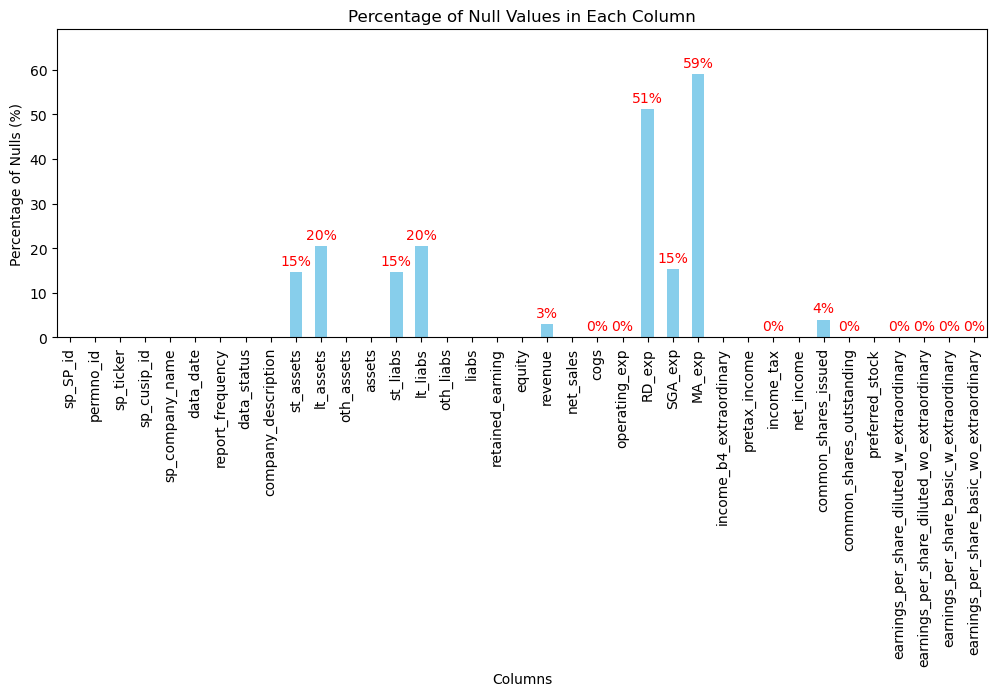

In [104]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## E1. Since revenue is similar to net_sales, and net_sales have no null values, we will drop revenue and keep only net_sales (See step K1)

## Investigate companies with missing cogs

permno == 27887, 70578, 64282, 77338, 16692

In [105]:
df[df["cogs"].isnull()]["permno_id"].unique()

array([27887, 70578, 64282, 75607, 77338, 16692])

## Investigate permno == 27887

In [106]:
permno = 27887

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
640,3558.0,NaN,71.0


In [107]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
638,BAXTER INTERNATIONAL INC,2021-09-30,3226.0,1667.0,450.0
639,BAXTER INTERNATIONAL INC,2021-12-31,3514.0,1811.0,238.0
640,BAXTER INTERNATIONAL INC,2022-03-31,3558.0,NaN,71.0
641,BAXTER INTERNATIONAL INC,2022-06-30,3594.0,3745.0,252.0
642,BAXTER INTERNATIONAL INC,2022-09-30,3609.0,1916.0,-2937.0


### F1. Find the cogs for the missing date from their 10-Q Part I Item 1.

https://d18rn0p25nwr6d.cloudfront.net/CIK-0000010456/d9674407-f5f6-4121-b77e-d9aeb1e149a0.pdf

In [108]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2022-03-31"), 'cogs'] = 2359.0

In [109]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
638,BAXTER INTERNATIONAL INC,2021-09-30,3226.0,1667.0,450.0
639,BAXTER INTERNATIONAL INC,2021-12-31,3514.0,1811.0,238.0
640,BAXTER INTERNATIONAL INC,2022-03-31,3558.0,2359.0,71.0
641,BAXTER INTERNATIONAL INC,2022-06-30,3594.0,3745.0,252.0
642,BAXTER INTERNATIONAL INC,2022-09-30,3609.0,1916.0,-2937.0


## Investigate permno == 70578

In [110]:
permno = 70578

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
1783,2924.7,NaN,296.5


In [111]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
1781,ECOLAB INC,2018-09-30,3747.2,1952.5,435.4
1782,ECOLAB INC,2018-12-31,3760.5,1973.1,395.1
1783,ECOLAB INC,2019-03-31,2924.7,NaN,296.5
1784,ECOLAB INC,2019-06-30,3169.1,3059.7,368.6
1785,ECOLAB INC,2019-09-30,3224.0,1575.2,464.2


### F2. Find the cogs for the missing date from their 10-Q Part I Item 1.

https://d18rn0p25nwr6d.cloudfront.net/CIK-0000031462/09972b9b-01e2-4e0d-85a9-fbf5973dba31.pdf

In [112]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2019-03-31"), 'cogs'] = 2096.7

In [113]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
1781,ECOLAB INC,2018-09-30,3747.2,1952.5,435.4
1782,ECOLAB INC,2018-12-31,3760.5,1973.1,395.1
1783,ECOLAB INC,2019-03-31,2924.7,2096.7,296.5
1784,ECOLAB INC,2019-06-30,3169.1,3059.7,368.6
1785,ECOLAB INC,2019-09-30,3224.0,1575.2,464.2


## Investigate permno == 64282

In [114]:
permno = 64282

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
3175,1654.0,NaN,-297.0


In [115]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
3173,BATH & BODY WORKS INC,2019-10-31,2677.0,1788.0,-252.0
3174,BATH & BODY WORKS INC,2020-01-31,4707.0,2769.0,-192.0
3175,BATH & BODY WORKS INC,2020-04-30,1654.0,NaN,-297.0
3176,BATH & BODY WORKS INC,2020-07-31,360.0,1093.0,-50.0
3177,BATH & BODY WORKS INC,2020-10-31,1702.0,791.0,331.0


### F3. Find the cogs for the missing date from their 10-Q Part I Item 1.

https://investors.bbwinc.com/static-files/1fe84616-3f39-4f33-9338-3a52a806d191

In [116]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2020-04-30"), 'cogs'] = 1366.0

In [117]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
3173,BATH & BODY WORKS INC,2019-10-31,2677.0,1788.0,-252.0
3174,BATH & BODY WORKS INC,2020-01-31,4707.0,2769.0,-192.0
3175,BATH & BODY WORKS INC,2020-04-30,1654.0,1366.0,-297.0
3176,BATH & BODY WORKS INC,2020-07-31,360.0,1093.0,-50.0
3177,BATH & BODY WORKS INC,2020-10-31,1702.0,791.0,331.0


## Investigate permno == 75607

In [118]:
permno = 75607

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
6532,612.0,NaN,-60.0


In [119]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
6530,BROWN & BROWN INC,2023-12-31,1026.2,750.8,268.7
6531,GEN DIGITAL INC,2018-03-31,1210.0,163.0,-59.0
6532,GEN DIGITAL INC,2018-06-30,612.0,NaN,-60.0
6533,GEN DIGITAL INC,2018-09-30,612.0,138.0,-8.0
6534,GEN DIGITAL INC,2018-12-31,615.0,69.0,65.0


### F4. Find the cogs for the missing date from their 10-Q Part I Item 1.

Their 10-Q for this period was not available, so we will use the same value as the next Q

In [120]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2018-06-30"), 'cogs'] = 138.0

In [121]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
6530,BROWN & BROWN INC,2023-12-31,1026.2,750.8,268.7
6531,GEN DIGITAL INC,2018-03-31,1210.0,163.0,-59.0
6532,GEN DIGITAL INC,2018-06-30,612.0,138.0,-60.0
6533,GEN DIGITAL INC,2018-09-30,612.0,138.0,-8.0
6534,GEN DIGITAL INC,2018-12-31,615.0,69.0,65.0


## Investigate permno == 77338

In [122]:
permno = 77338

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
7589,1155.3,NaN,289.0


In [123]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
7587,ROPER TECHNOLOGIES INC,2020-09-30,1198.2,388.3,234.4
7588,ROPER TECHNOLOGIES INC,2020-12-31,1335.6,434.7,255.8
7589,ROPER TECHNOLOGIES INC,2021-03-31,1155.3,NaN,289.0
7590,ROPER TECHNOLOGIES INC,2021-06-30,1189.8,383.0,286.3
7591,ROPER TECHNOLOGIES INC,2021-09-30,1232.1,208.8,289.5


### F5. Find the cogs for the missing date from their 10-Q Part I Item 1.

https://investors.bbwinc.com/static-files/1fe84616-3f39-4f33-9338-3a52a806d191

In [124]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2021-03-31"), 'cogs'] = 534.8

In [125]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
7587,ROPER TECHNOLOGIES INC,2020-09-30,1198.2,388.3,234.4
7588,ROPER TECHNOLOGIES INC,2020-12-31,1335.6,434.7,255.8
7589,ROPER TECHNOLOGIES INC,2021-03-31,1155.3,534.8,289.0
7590,ROPER TECHNOLOGIES INC,2021-06-30,1189.8,383.0,286.3
7591,ROPER TECHNOLOGIES INC,2021-09-30,1232.1,208.8,289.5


## Investigate permno == 16692

In [126]:
permno = 16692

index_null = df[(df['permno_id'] == permno) & (df['cogs'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["cogs"].isnull())][["net_sales", "cogs", "net_income"]]

,net_sales,cogs,net_income
8723,616.8,NaN,-36.8


In [127]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
8721,INGERSOLL RAND INC,2019-09-30,596.7,364.7,41.3
8722,INGERSOLL RAND INC,2019-12-31,605.8,369.5,25.7
8723,INGERSOLL RAND INC,2020-03-31,616.8,NaN,-36.8
8724,INGERSOLL RAND INC,2020-06-30,1025.4,1059.0,-177.6
8725,INGERSOLL RAND INC,2020-09-30,1112.5,662.2,29.5


### F6. Find the cogs for the missing date from their 10-Q Part I Item 1.

https://d18rn0p25nwr6d.cloudfront.net/CIK-0001699150/ea220d80-9263-473e-a638-84d986168b0a.pdf

In [128]:
df.loc[(df['permno_id'] == permno) & (df['data_date'] == "2020-03-31"), 'cogs'] = 555.4

In [129]:
df.iloc[beg:end][["sp_company_name", "data_date", "net_sales", "cogs", "net_income"]]

,sp_company_name,data_date,net_sales,cogs,net_income
8721,INGERSOLL RAND INC,2019-09-30,596.7,364.7,41.3
8722,INGERSOLL RAND INC,2019-12-31,605.8,369.5,25.7
8723,INGERSOLL RAND INC,2020-03-31,616.8,555.4,-36.8
8724,INGERSOLL RAND INC,2020-06-30,1025.4,1059.0,-177.6
8725,INGERSOLL RAND INC,2020-09-30,1112.5,662.2,29.5


# Take another look at the null analysis

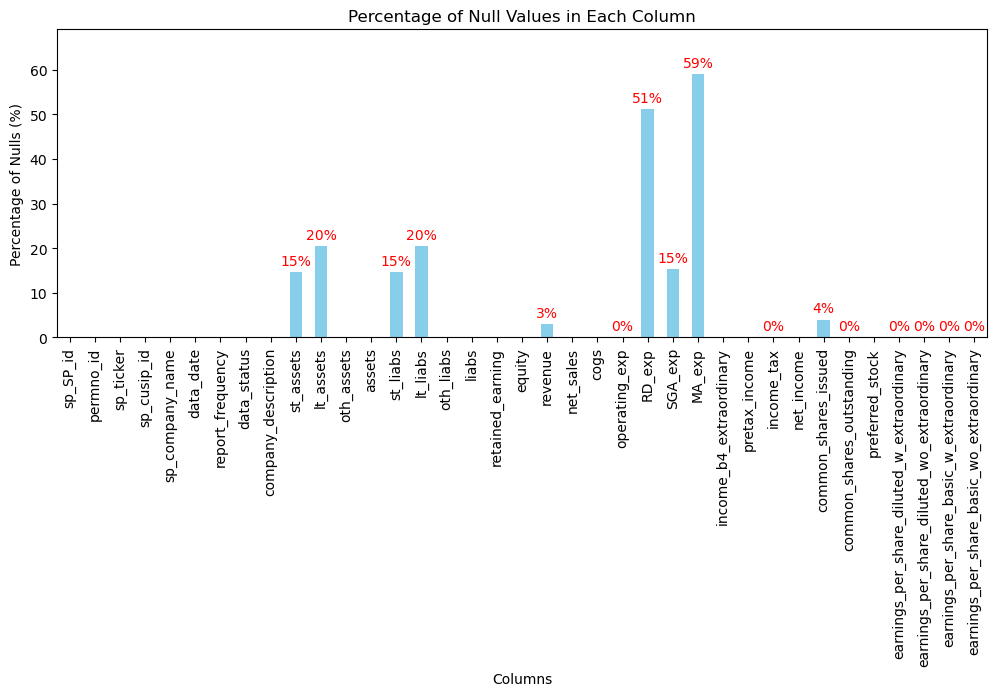

In [130]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## Investigate companies with missing operating_exp

permno == 27887, 70578, 64282, 77338, 16692

In [131]:
df[df["operating_exp"].isnull()]["permno_id"].unique()

array([27887, 70578, 64282, 75607, 77338, 16692])

### G1. We will use net_sales - cogs - pretax_income as an approximation for operating_exp

In [132]:
for permno in df[df["operating_exp"].isnull()]["permno_id"].unique():
  permno_index = df[(df["permno_id"] == permno) & (df["operating_exp"].isnull())].index
  df.loc[(df['permno_id'] == permno) & (df["operating_exp"].isnull()), 'operating_exp'] = df.loc[(df['permno_id'] == permno) & (df["operating_exp"].isnull()), 'net_sales'] - df.loc[(df['permno_id'] == permno) & (df["operating_exp"].isnull()), 'cogs'] - df.loc[(df['permno_id'] == permno) & (df["operating_exp"].isnull()), 'pretax_income']
  display(df.iloc[permno_index][["net_sales", "cogs", "operating_exp", "pretax_income"]])

,net_sales,cogs,operating_exp,pretax_income
640,3558.0,2359.0,1185.0,14.0


,net_sales,cogs,operating_exp,pretax_income
1783,2924.7,2096.7,542.5,285.5


,net_sales,cogs,operating_exp,pretax_income
3175,1654.0,1366.0,700.0,-412.0


,net_sales,cogs,operating_exp,pretax_income
6532,612.0,138.0,570.0,-96.0


,net_sales,cogs,operating_exp,pretax_income
7589,1155.3,534.8,336.1,284.4


,net_sales,cogs,operating_exp,pretax_income
8723,616.8,555.4,169.6,-108.2


# Take another look at null analysis

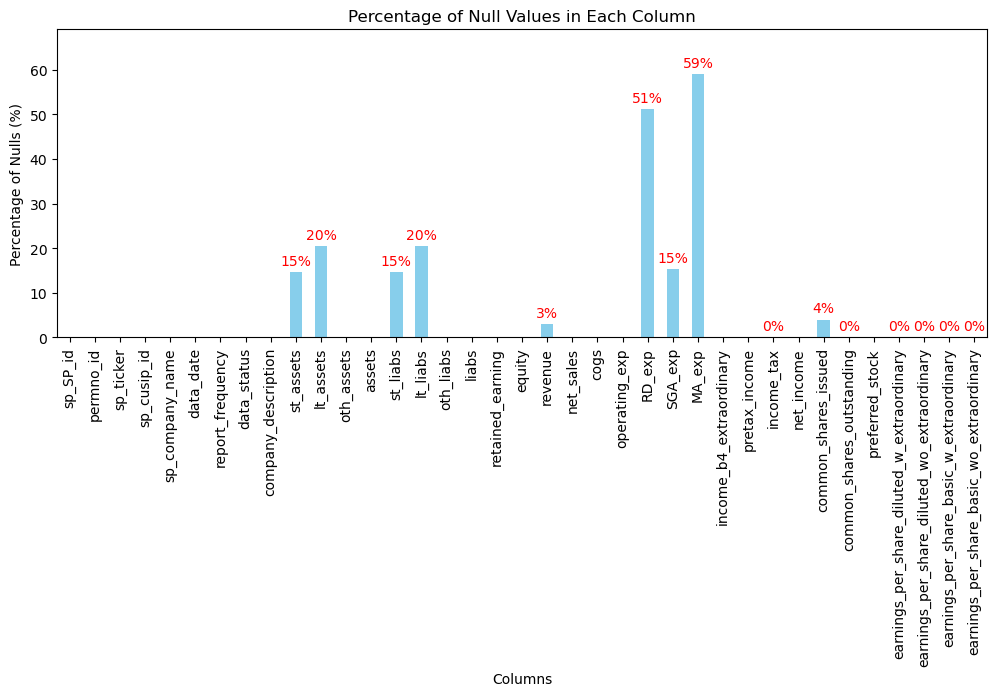

In [133]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## Investigate companies with missing income tax

permno == 79145

In [134]:
df[df["income_tax"].isnull()]["permno_id"].unique()

array([79145])

### H1. We will use pretax_income - net_income as an approximation for income_tax

In [135]:
permno = 79145

index_null = df[(df['permno_id'] == permno) & (df['income_tax'].isnull())].index

beg = (index_null[0] - 2)
end = (index_null[0] + 3)

df[(df["permno_id"] == permno) & (df["income_tax"].isnull())][["pretax_income", "income_tax", "net_income"]]

,pretax_income,income_tax,net_income
8080,218.653,NaN,218.653
8081,466.295,NaN,466.295
8082,810.391,NaN,810.391
8083,320.453,NaN,315.703
8084,256.806,NaN,249.681
8085,479.955,NaN,472.830
8086,890.365,NaN,883.240
8087,280.474,NaN,273.136
8088,-1437.035,NaN,-1444.479
8089,-1631.848,NaN,-1639.292


In [136]:
df.loc[(df["permno_id"] == permno) & (df["income_tax"].isnull()), "income_tax"] = (
    df["pretax_income"] - df["net_income"]
)

In [137]:
df[df["permno_id"] == permno][["pretax_income", "income_tax", "net_income"]]

,pretax_income,income_tax,net_income
8080,218.653,0.000,218.653
8081,466.295,0.000,466.295
8082,810.391,0.000,810.391
8083,320.453,4.750,315.703
8084,256.806,7.125,249.681
8085,479.955,7.125,472.830
8086,890.365,7.125,883.240
8087,280.474,7.338,273.136
8088,-1437.035,7.444,-1444.479
8089,-1631.848,7.444,-1639.292


# Take another look at the null analysis

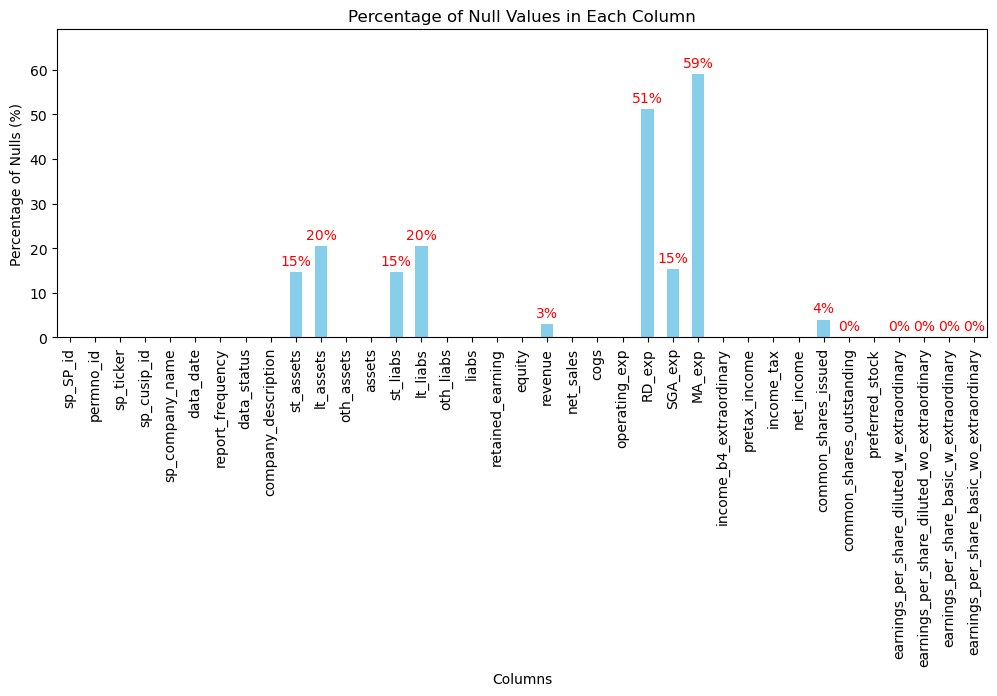

In [138]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

## I1. The columns with nulls in equity & EPS are not so easy to compute, we'll use forward fill to fill them for now and consider spending more time to find the actual data later if needed

In [139]:
df[['common_shares_issued',
    'common_shares_outstanding',
    'preferred_stock',
    'earnings_per_share_diluted_w_extraordinary',
    'earnings_per_share_diluted_wo_extraordinary',
    'earnings_per_share_basic_w_extraordinary',
    'earnings_per_share_basic_wo_extraordinary']] = df.groupby('permno_id')[['common_shares_issued',
    'common_shares_outstanding',
    'preferred_stock',
    'earnings_per_share_diluted_w_extraordinary',
    'earnings_per_share_diluted_wo_extraordinary',
    'earnings_per_share_basic_w_extraordinary',
    'earnings_per_share_basic_wo_extraordinary']].ffill()

# (Almost) final null analysis

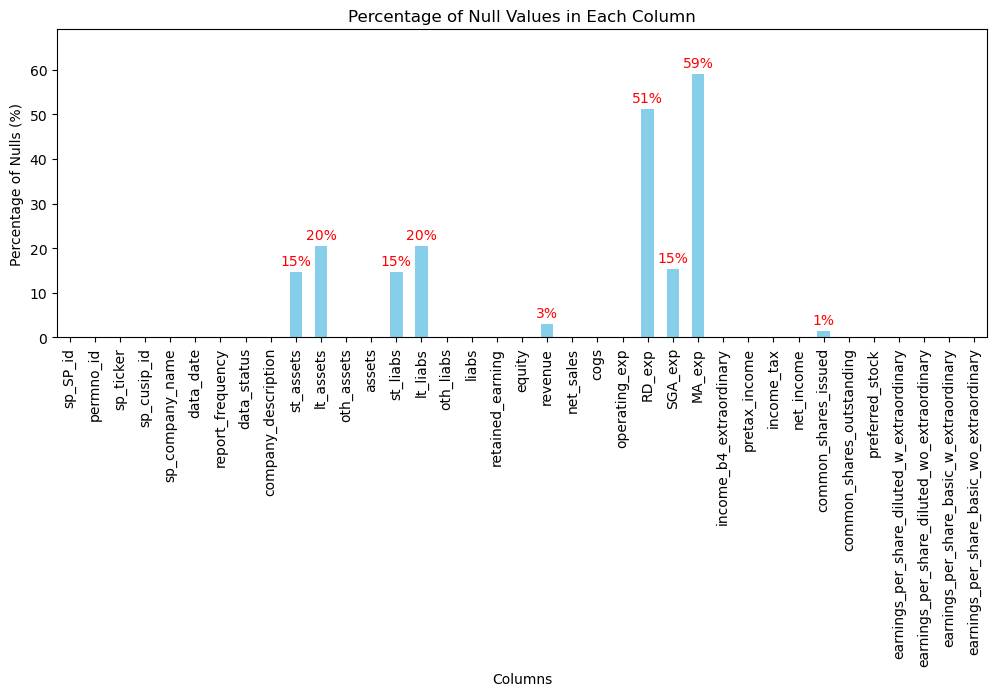

In [140]:
# Count the number of nulls in each column
null_counts = df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title('Percentage of Null Values in Each Column')
plt.xlabel('Columns')
plt.ylim(0, max(null_percentages.values)+10)
plt.ylabel('Percentage of Nulls (%)')

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(f'{percentage:.0f}%', xy=(i, percentage), xytext=(0, 3),
                    textcoords='offset points', ha='center', va='bottom', color='red')

plt.show()

In [141]:
for permno in df[df["common_shares_issued"].isnull()]["permno_id"].unique():
  display(permno)
  display(df[df["permno_id"] == permno][["data_date", "common_shares_issued"]])

85257

,data_date,common_shares_issued
336,2018-03-31,NaN
337,2018-06-30,NaN
338,2018-09-30,NaN
339,2018-12-31,263.645
340,2019-03-31,263.645
341,2019-06-30,263.645
342,2019-09-30,263.645
343,2019-12-31,265.584
344,2020-03-31,265.584
345,2020-06-30,265.584


10516

,data_date,common_shares_issued
480,2018-03-31,NaN
481,2018-06-30,NaN
482,2018-09-30,NaN
483,2018-12-31,716.1
484,2019-03-31,716.1
485,2019-06-30,716.1
486,2019-09-30,716.1
487,2019-12-31,715.8
488,2020-03-31,715.8
489,2020-06-30,715.8


29946

,data_date,common_shares_issued
840,2018-01-31,NaN
841,2018-04-30,484.532
842,2018-07-31,484.532
843,2018-10-31,484.532
844,2019-01-31,484.532
845,2019-04-30,484.532
846,2019-07-31,484.532
847,2019-10-31,484.532
848,2020-01-31,484.532
849,2020-04-30,484.532


30681

,data_date,common_shares_issued
1707,2018-03-31,NaN
1708,2018-06-30,NaN
1709,2018-09-30,NaN
1710,2018-12-31,297.2
1711,2019-03-31,297.2
1712,2019-06-30,297.2
1713,2019-09-30,297.2
1714,2019-12-31,297.2
1715,2020-03-31,297.2
1716,2020-06-30,297.2


25785

,data_date,common_shares_issued
2139,2018-03-31,NaN
2140,2018-06-30,NaN
2141,2018-09-30,NaN
2142,2018-12-31,NaN
2143,2019-03-31,NaN
2144,2019-06-30,NaN
2145,2019-09-30,NaN
2146,2019-12-31,NaN
2147,2020-03-31,NaN
2148,2020-06-30,NaN


53065

,data_date,common_shares_issued
2835,2018-03-31,NaN
2836,2018-06-30,NaN
2837,2018-09-30,NaN
2838,2018-12-31,383.6
2839,2019-03-31,386.2
2840,2019-06-30,386.4
2841,2019-09-30,386.9
2842,2019-12-31,387.0
2843,2020-03-31,389.5
2844,2020-06-30,389.6


45356

,data_date,common_shares_issued
2907,2018-03-31,NaN
2908,2018-06-30,NaN
2909,2018-09-30,950.970
2910,2018-12-31,950.970
2911,2019-03-31,950.970
2912,2019-06-30,950.970
2913,2019-09-30,804.495
2914,2019-12-31,804.495
2915,2020-03-31,804.495
2916,2020-06-30,804.495


46886

,data_date,common_shares_issued
2931,2018-03-31,NaN
2932,2018-06-30,262.718
2933,2018-09-30,262.718
2934,2018-12-31,262.718
2935,2019-03-31,161.912
2936,2019-06-30,276.202
2937,2019-09-30,276.202
2938,2019-12-31,276.202
2939,2020-03-31,276.202
2940,2020-06-30,277.526


89757

,data_date,common_shares_issued
2955,2018-01-31,NaN
2956,2018-04-30,NaN
2957,2018-07-31,NaN


50876

,data_date,common_shares_issued
3142,2018-03-31,NaN
3143,2018-06-30,NaN
3144,2018-09-30,NaN
3145,2018-12-31,1057.639
3146,2019-03-31,971.363
3147,2019-06-30,965.957
3148,2019-09-30,960.576
3149,2019-12-31,958.056
3150,2020-03-31,956.929
3151,2020-06-30,956.953


57809

,data_date,common_shares_issued
3750,2018-01-31,NaN
3751,2018-04-30,NaN
3752,2018-07-31,NaN
3753,2018-10-31,98.023
3754,2019-01-31,98.023
3755,2019-04-30,98.023
3756,2019-07-31,98.023
3757,2019-10-31,98.023
3758,2020-01-31,98.023
3759,2020-04-30,98.023


22509

,data_date,common_shares_issued
4062,2018-03-31,NaN
4063,2018-06-30,581.146
4064,2018-09-30,581.146
4065,2018-12-31,581.146
4066,2019-03-31,581.146
4067,2019-06-30,581.146
4068,2019-09-30,581.146
4069,2019-12-31,581.146
4070,2020-03-31,581.146
4071,2020-06-30,581.146


21936

,data_date,common_shares_issued
4278,2018-03-31,NaN
4279,2018-06-30,NaN
4280,2018-09-30,NaN
4281,2018-12-31,9332.0
4282,2019-03-31,9358.0
4283,2019-06-30,9363.0
4284,2019-09-30,9366.0
4285,2019-12-31,9369.0
4286,2020-03-31,9393.0
4287,2020-06-30,9394.0


65402

,data_date,common_shares_issued
4638,2018-03-31,NaN
4639,2018-06-30,NaN
4640,2018-09-30,NaN
4641,2018-12-31,190.707
4642,2019-03-31,190.707
4643,2019-06-30,190.707
4644,2019-09-30,190.707
4645,2019-12-31,190.708
4646,2020-03-31,190.708
4647,2020-06-30,190.708


58683

,data_date,common_shares_issued
4782,2018-03-31,NaN
4783,2018-06-30,NaN
4784,2018-09-30,NaN
4785,2018-12-31,807.612
4786,2019-03-31,807.612
4787,2019-06-30,807.612
4788,2019-09-30,807.612
4789,2019-12-31,807.612
4790,2020-03-31,807.612
4791,2020-06-30,807.612


43350

,data_date,common_shares_issued
4830,2018-03-31,NaN
4831,2018-06-30,NaN
4832,2018-09-30,NaN
4833,2018-12-31,176.903
4834,2019-03-31,176.903
4835,2019-06-30,176.903
4836,2019-09-30,176.903
4837,2019-12-31,176.903
4838,2020-03-31,176.903
4839,2020-06-30,176.903


23579

,data_date,common_shares_issued
5022,2018-03-31,NaN
5023,2018-06-30,NaN
5024,2018-09-30,NaN
5025,2018-12-31,238.2
5026,2019-03-31,238.2
5027,2019-06-30,238.2
5028,2019-09-30,238.2
5029,2019-12-31,228.4
5030,2020-03-31,228.4
5031,2020-06-30,228.4


91103

,data_date,common_shares_issued
5142,2018-03-31,NaN
5143,2018-06-30,NaN
5144,2018-09-30,NaN
5145,2018-12-31,NaN
5146,2019-03-31,NaN
5147,2019-06-30,NaN
5148,2019-09-30,NaN
5149,2019-12-31,NaN
5150,2020-03-31,NaN
5151,2020-06-30,NaN


17830

,data_date,common_shares_issued
5286,2018-03-31,NaN
5287,2018-06-30,NaN
5288,2018-09-30,NaN
5289,2018-12-31,1446.961
5290,2019-03-31,1446.961
5291,2019-06-30,1446.961
5292,2019-09-30,1446.961
5293,2019-12-31,1450.845
5294,2020-03-31,1450.845
5295,2020-06-30,1450.845


11403

,data_date,common_shares_issued
5947,2018-03-31,NaN
5948,2018-06-30,NaN
5949,2018-09-30,NaN
5950,2018-12-31,329.159
5951,2019-03-31,329.159
5952,2019-06-30,329.159
5953,2019-09-30,329.159
5954,2019-12-31,329.159
5955,2020-03-31,329.159
5956,2020-06-30,329.159


76841

,data_date,common_shares_issued
7361,2018-03-31,NaN
7362,2018-06-30,NaN
7363,2018-09-30,NaN
7364,2018-12-31,221.0
7365,2019-03-31,219.0
7366,2019-06-30,208.6
7367,2019-09-30,205.7
7368,2019-12-31,198.0
7369,2020-03-31,191.1
7370,2020-06-30,182.1


77338

,data_date,common_shares_issued
7577,2018-03-31,NaN
7578,2018-06-30,NaN
7579,2018-09-30,NaN
7580,2018-12-31,105.2
7581,2019-03-31,105.2
7582,2019-06-30,105.2
7583,2019-09-30,105.2
7584,2019-12-31,105.9
7585,2020-03-31,105.9
7586,2020-06-30,105.9


78975

,data_date,common_shares_issued
7960,2018-01-31,NaN
7961,2018-04-30,NaN
7962,2018-07-31,NaN
7963,2018-10-31,NaN
7964,2019-01-31,NaN
7965,2019-04-30,NaN
7966,2019-07-31,NaN
7967,2019-10-31,NaN
7968,2020-01-31,NaN
7969,2020-04-30,NaN


79545

,data_date,common_shares_issued
8237,2018-03-31,NaN
8238,2018-06-30,NaN
8239,2018-09-30,NaN
8240,2018-12-31,246.387
8241,2019-03-31,246.387
8242,2019-06-30,246.387
8243,2019-09-30,246.387
8244,2019-12-31,246.387
8245,2020-03-31,246.387
8246,2020-06-30,246.387


85913

,data_date,common_shares_issued
8307,2018-03-31,NaN
8308,2018-06-30,NaN
8309,2018-09-30,NaN
8310,2018-12-31,NaN
8311,2019-03-31,NaN
8312,2019-06-30,NaN
8313,2019-09-30,NaN
8314,2019-12-31,NaN
8315,2020-03-31,NaN
8316,2020-06-30,NaN


83639

,data_date,common_shares_issued
9765,2018-03-31,NaN
9766,2018-06-30,NaN
9767,2018-09-30,NaN
9768,2018-12-31,261.224
9769,2019-03-31,261.224
9770,2019-06-30,261.224
9771,2019-09-30,261.224
9772,2019-12-31,261.267
9773,2020-03-31,261.267
9774,2020-06-30,261.267


88446

,data_date,common_shares_issued
11008,2018-03-31,NaN
11009,2018-06-30,NaN
11010,2018-09-30,NaN
11011,2018-12-31,192.0
11012,2019-03-31,192.0
11013,2019-06-30,193.0
11014,2019-09-30,193.0
11015,2019-12-31,194.0
11016,2020-03-31,194.0
11017,2020-06-30,194.0


90227

,data_date,common_shares_issued
11799,2018-03-31,NaN
11800,2018-06-30,NaN
11801,2018-09-30,NaN
11802,2018-12-31,NaN
11803,2019-03-31,NaN
11804,2019-06-30,NaN
11805,2019-09-30,NaN
11806,2019-12-31,NaN
11807,2020-03-31,NaN
11808,2020-06-30,NaN


93246

,data_date,common_shares_issued
12699,2018-03-31,NaN
12700,2018-06-30,NaN
12701,2018-09-30,NaN
12702,2018-12-31,71.186
12703,2019-03-31,71.396
12704,2019-06-30,71.471
12705,2019-09-30,71.641
12706,2019-12-31,71.668
12707,2020-03-31,71.845
12708,2020-06-30,71.960


16048

,data_date,common_shares_issued
13089,2018-03-31,NaN
13090,2018-06-30,486.108
13091,2018-09-30,486.108
13092,2018-12-31,474.920
13093,2019-03-31,474.920
13094,2019-06-30,466.671
13095,2019-09-30,466.671
13096,2019-12-31,456.400
13097,2020-03-31,456.400
13098,2020-06-30,454.164


42877

,data_date,common_shares_issued
13185,2018-03-31,NaN
13186,2018-06-30,NaN
13187,2018-09-30,NaN
13188,2018-12-31,167.099
13189,2019-03-31,167.100
13190,2019-06-30,167.100
13191,2019-09-30,167.100
13192,2019-12-31,167.099
13193,2020-03-31,167.100
13194,2020-06-30,167.100


17750

,data_date,common_shares_issued
13209,2018-03-31,NaN
13210,2018-06-30,NaN
13211,2018-09-30,NaN
13212,2018-12-31,378.597
13213,2019-03-31,378.597
13214,2019-06-30,378.597
13215,2019-09-30,378.597
13216,2019-12-31,378.597
13217,2020-03-31,378.597
13218,2020-06-30,378.597


81472

,data_date,common_shares_issued
13325,2018-03-31,NaN
13326,2018-06-30,431.465
13327,2018-09-30,431.465
13328,2018-12-31,431.466
13329,2019-03-31,431.466
13330,2019-06-30,425.659
13331,2019-09-30,425.659
13332,2019-12-31,425.660
13333,2020-03-31,425.660
13334,2020-06-30,425.660


88362

,data_date,common_shares_issued
13349,2018-03-31,NaN
13350,2018-06-30,NaN
13351,2018-09-30,NaN
13352,2018-12-31,127.961
13353,2019-03-31,128.794
13354,2019-06-30,128.794
13355,2019-09-30,128.794
13356,2019-12-31,129.141
13357,2020-03-31,129.964
13358,2020-06-30,129.964


89927

,data_date,common_shares_issued
13373,2018-03-31,NaN
13374,2018-06-30,NaN
13375,2018-09-30,NaN
13376,2018-12-31,576.416
13377,2019-03-31,576.416
13378,2019-06-30,576.416
13379,2019-09-30,576.416
13380,2019-12-31,616.124
13381,2020-03-31,616.124
13382,2020-06-30,616.124


## J1. For the few with values after certain dates, use backward fill to fill the previous missing values

In [142]:
for permno in df[df["common_shares_issued"].isnull()]["permno_id"].unique():
  df_permno = df[df["permno_id"]==permno]
  df_permno["common_shares_issued"] = df_permno["common_shares_issued"].bfill()
  df = pd.concat([df[df["permno_id"]!=permno], df_permno]).reset_index(drop=True)

/tmp/ipykernel_622/208634582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_permno["common_shares_issued"] = df_permno["common_shares_issued"].bfill()


In [143]:
for permno in df[df["common_shares_issued"].isnull()]["permno_id"].unique():
  display(permno)
  display(df[df["permno_id"] == permno][["data_date", "common_shares_issued"]])

25785

,data_date,common_shares_issued
12674,2018-03-31,NaN
12675,2018-06-30,NaN
12676,2018-09-30,NaN
12677,2018-12-31,NaN
12678,2019-03-31,NaN
12679,2019-06-30,NaN
12680,2019-09-30,NaN
12681,2019-12-31,NaN
12682,2020-03-31,NaN
12683,2020-06-30,NaN


89757

,data_date,common_shares_issued
12770,2018-01-31,NaN
12771,2018-04-30,NaN
12772,2018-07-31,NaN


91103

,data_date,common_shares_issued
12965,2018-03-31,NaN
12966,2018-06-30,NaN
12967,2018-09-30,NaN
12968,2018-12-31,NaN
12969,2019-03-31,NaN
12970,2019-06-30,NaN
12971,2019-09-30,NaN
12972,2019-12-31,NaN
12973,2020-03-31,NaN
12974,2020-06-30,NaN


78975

,data_date,common_shares_issued
13085,2018-01-31,NaN
13086,2018-04-30,NaN
13087,2018-07-31,NaN
13088,2018-10-31,NaN
13089,2019-01-31,NaN
13090,2019-04-30,NaN
13091,2019-07-31,NaN
13092,2019-10-31,NaN
13093,2020-01-31,NaN
13094,2020-04-30,NaN


85913

,data_date,common_shares_issued
13133,2018-03-31,NaN
13134,2018-06-30,NaN
13135,2018-09-30,NaN
13136,2018-12-31,NaN
13137,2019-03-31,NaN
13138,2019-06-30,NaN
13139,2019-09-30,NaN
13140,2019-12-31,NaN
13141,2020-03-31,NaN
13142,2020-06-30,NaN


90227

,data_date,common_shares_issued
13205,2018-03-31,NaN
13206,2018-06-30,NaN
13207,2018-09-30,NaN
13208,2018-12-31,NaN
13209,2019-03-31,NaN
13210,2019-06-30,NaN
13211,2019-09-30,NaN
13212,2019-12-31,NaN
13213,2020-03-31,NaN
13214,2020-06-30,NaN


## J2. The remaining permnos have no common_shares_issued from the dataset at all, we will treat them as 0, although we know this is not accurate, will investigate if time allows later

In [144]:
permnos_to_fill = df[df["common_shares_issued"].isnull()]["permno_id"].unique()
df.loc[df['permno_id'].isin(permnos_to_fill) & df['common_shares_issued'].isnull(), 'common_shares_issued'] = 0

# Final null analysis

## K1. Since we already have some columns with similar info as the few columns with many nulls, drop the ones with many nulls

In [145]:
columns_to_drop = ["st_assets", "lt_assets", "st_liabs", "lt_liabs", "revenue", "RD_exp", "SGA_exp", "MA_exp"]
df = df.drop(columns=columns_to_drop)
df.columns

Index(['sp_SP_id', 'permno_id', 'sp_ticker', 'sp_cusip_id', 'sp_company_name',
       'data_date', 'report_frequency', 'data_status', 'company_description',
       'oth_assets', 'assets', 'oth_liabs', 'liabs', 'retained_earning',
       'equity', 'net_sales', 'cogs', 'operating_exp',
       'income_b4_extraordinary', 'pretax_income', 'income_tax', 'net_income',
       'common_shares_issued', 'common_shares_outstanding', 'preferred_stock',
       'earnings_per_share_diluted_w_extraordinary',
       'earnings_per_share_diluted_wo_extraordinary',
       'earnings_per_share_basic_w_extraordinary',
       'earnings_per_share_basic_wo_extraordinary'],
      dtype='object')

## K2. Confirm no null values

In [146]:
assert len(df[df.isnull().any(axis=1)]) == 0

## K3. Confirm each PERMNO contains at most n_days records

In [147]:
assert df["permno_id"].value_counts().max() <= df["data_date"].nunique()

## K4. Cast to appropriate type

In [148]:
df.columns

Index(['sp_SP_id', 'permno_id', 'sp_ticker', 'sp_cusip_id', 'sp_company_name',
       'data_date', 'report_frequency', 'data_status', 'company_description',
       'oth_assets', 'assets', 'oth_liabs', 'liabs', 'retained_earning',
       'equity', 'net_sales', 'cogs', 'operating_exp',
       'income_b4_extraordinary', 'pretax_income', 'income_tax', 'net_income',
       'common_shares_issued', 'common_shares_outstanding', 'preferred_stock',
       'earnings_per_share_diluted_w_extraordinary',
       'earnings_per_share_diluted_wo_extraordinary',
       'earnings_per_share_basic_w_extraordinary',
       'earnings_per_share_basic_wo_extraordinary'],
      dtype='object')

In [149]:
float_cols = ['oth_assets', 'assets', 'oth_liabs', 'liabs', 'retained_earning',
       'equity', 'net_sales', 'cogs', 'operating_exp',
       'income_b4_extraordinary', 'pretax_income', 'income_tax', 'net_income',
       'common_shares_issued', 'common_shares_outstanding', 'preferred_stock',
       'earnings_per_share_diluted_w_extraordinary',
       'earnings_per_share_diluted_wo_extraordinary',
       'earnings_per_share_basic_w_extraordinary',
       'earnings_per_share_basic_wo_extraordinary']
str_cols = ['sp_SP_id', 'permno_id', 'sp_ticker', 'sp_cusip_id', 'sp_company_name', 'report_frequency', 'data_status', 'company_description']

In [150]:
df[float_cols] = df[float_cols].astype(float)
df[str_cols] = df[str_cols].astype(str)

# Save the cleaned df as csv & parquet

In [151]:
df.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_compustat_2018-2023_clean.csv",
    index=False,
)
df.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_compustat_2018-2023_clean.parquet")

In [152]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_compustat_2018-2023_clean.parquet")
assert df.equals(reload)

reload.head()

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,oth_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
0,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-03-31,Q,3,"American Airlines Group Inc., through its subs...",9274.0,...,238.0,79.0,159.0,467.390,467.390,0.0,0.34,0.34,0.34,0.34
1,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-06-30,Q,3,"American Airlines Group Inc., through its subs...",9022.0,...,756.0,199.0,557.0,460.502,460.502,0.0,1.20,1.20,1.20,1.20
2,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-09-30,Q,3,"American Airlines Group Inc., through its subs...",8914.0,...,495.0,123.0,372.0,460.559,460.559,0.0,0.81,0.81,0.81,0.81
3,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-12-31,Q,3,"American Airlines Group Inc., through its subs...",8694.0,...,395.0,71.0,324.0,460.611,460.611,0.0,0.70,0.70,0.71,0.71
4,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2019-03-31,Q,3,"American Airlines Group Inc., through its subs...",8599.0,...,245.0,60.0,185.0,444.216,444.216,0.0,0.41,0.41,0.41,0.41


# Upload the parquet to s3

In [153]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_compustat_2018-2023_clean.parquet",
    bucket,
    "CRSP/crsp_compustat_2018-2023_clean.parquet",
)

In [154]:
reload_path = s3_download("CRSP/crsp_compustat_2018-2023_clean.parquet")

In [156]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_compustat_2018-2023_clean.parquet")
assert df.equals(reload)

reload.head()

,sp_SP_id,permno_id,sp_ticker,sp_cusip_id,sp_company_name,data_date,report_frequency,data_status,company_description,oth_assets,...,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
0,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-03-31,Q,3,"American Airlines Group Inc., through its subs...",9274.0,...,238.0,79.0,159.0,467.390,467.390,0.0,0.34,0.34,0.34,0.34
1,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-06-30,Q,3,"American Airlines Group Inc., through its subs...",9022.0,...,756.0,199.0,557.0,460.502,460.502,0.0,1.20,1.20,1.20,1.20
2,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-09-30,Q,3,"American Airlines Group Inc., through its subs...",8914.0,...,495.0,123.0,372.0,460.559,460.559,0.0,0.81,0.81,0.81,0.81
3,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2018-12-31,Q,3,"American Airlines Group Inc., through its subs...",8694.0,...,395.0,71.0,324.0,460.611,460.611,0.0,0.70,0.70,0.71,0.71
4,1045,21020,AAL,02376R102,AMERICAN AIRLINES GROUP INC,2019-03-31,Q,3,"American Airlines Group Inc., through its subs...",8599.0,...,245.0,60.0,185.0,444.216,444.216,0.0,0.41,0.41,0.41,0.41
